In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import shutil
import math

import warnings
warnings.filterwarnings('ignore')

In [3]:
def summed_variations(selected_bool_table, all_subunits):
    """
    Processes the 'selected_bool_table' DataFrame by grouping it based on 'Accession' and 'Strand',
    summing values, and updating specific subunit columns to boolean values.

    Parameters:
    - selected_bool_table (pd.DataFrame): Input DataFrame containing subunit data.
    - all_subunits (list): List of subunit column names to process.

    Returns:
    - pd.DataFrame: Processed DataFrame with summed values and boolean subunit columns.
    """
    # Group by 'Accession' and 'Strand', summing the numeric values
    bool_table = (
        selected_bool_table.groupby(['Accession', 'Strand'])
        .sum()
        .reset_index()
        .drop(columns=['Variation'], errors='ignore')  # Drop 'Variation' if it exists
    )

    # Update subunit columns to boolean values
    bool_table[all_subunits] = bool_table[all_subunits].ge(1)
    
    return bool_table

In [4]:
def classify_complex_types(bool_table, combinations, all_subunits):
    # Initialize a new column 'Variation' with the default value '<Nuo13'
    bool_table['Variation'] = 'Nuo-Partial'
    
    # Iterate over each combination name and its corresponding true subunits
    for name, true_subunits in (combinations.items()):
        # Identify subunits that are not in the true subunits list (false subunits)
        false_subunits = [subunit for subunit in all_subunits if subunit not in true_subunits]
        
        # Create a mask to identify rows where all true subunits are present
        # and none of the false subunits are present
        match_mask = (bool_table[true_subunits].all(axis=1)) & (~bool_table[false_subunits].any(axis=1))
        
        # Update the 'Variation' column for rows that match the mask with the current name
        bool_table.loc[match_mask, 'Variation'] = name
    
    # Return the updated DataFrame with the classified complex types
    return bool_table

combinations = {
    'Nuo14': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13': ['NuoA', 'NuoB', 'NuoCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo12': ['NuoA', 'NuoBCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo14-EF': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13-EF': ['NuoA', 'NuoB', 'NuoCD', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo14-EFG': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13-EFG': ['NuoA', 'NuoB', 'NuoCD', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN']
}

In [5]:
nr_genomes_dataset = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/02-Genome-Metadata/genomes_dataset_unique.csv')
taxonomy = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/03-Taxonomy-Metadata/taxonomy.csv')

genomes_dataset = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/02-Genome-Metadata/genomes_dataset.csv')
genomes_metadata = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/02-Genome-Metadata/genomes_metadata.csv')

genomes_info = pd.merge(genomes_metadata[['Accession', 'GenomeFile', 'Replicon']], 
                        genomes_dataset[['Organism', 'Species', 'GenomeFile']])

nuohmmer_filtered = pd.read_csv("/Users/akshayonly/Work/04-Complex-I/Data/04-HMM-Analysis-Data/02-HMM-Subunits-Search-Processed/nuohmmer_filtered.csv")
nuohmmer_unfiltered = pd.read_csv("/Users/akshayonly/Work/04-Complex-I/Data/04-HMM-Analysis-Data/02-HMM-Subunits-Search-Processed/nuohmmer_unfiltered.csv")

nuo_bool = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/04-HMM-Analysis-Data/04-HMM-Subunits-Tables/nuo_bool_filtered.csv')
nuo_count = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/04-HMM-Analysis-Data/04-HMM-Subunits-Tables/nuo_count_filtered.csv')

In [6]:
# Define all subunits
subunit_columns = [
    'NuoA', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 'NuoD', 'NuoE',
    'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL',
    'NuoM', 'NuoN'
]

# Summarize subunits and drop unnecessary columns
aggregated_subunit_data = (
    nuo_bool.groupby('Accession')
    .sum()
    .reset_index()
    .drop(columns=['Variation', 'Cluster', 'Strand'], errors='ignore')  # Drop columns if they exist
)

# Convert subunit counts to boolean (True if count >= 1)
aggregated_subunit_data[subunit_columns] = aggregated_subunit_data[subunit_columns].ge(1)

# Classify complex types
aggregated_subunit_data = classify_complex_types(aggregated_subunit_data, combinations, subunit_columns)

# Merge with genome information
nuo_bool = genomes_info.merge(nuo_bool)
aggregated_subunit_data = genomes_info.merge(aggregated_subunit_data)

# Separate complete and incomplete datasets
complete_variations = aggregated_subunit_data[aggregated_subunit_data['Variation'] != 'Nuo-Partial']
incomplete_variations = aggregated_subunit_data[aggregated_subunit_data['Variation'] == 'Nuo-Partial']

# Further classify complete variations
standard_complete_variations = complete_variations[
    complete_variations['Variation'].isin(['Nuo13', 'Nuo14', 'Nuo12'])
]

n_module_variations = complete_variations[
    complete_variations['Variation'].isin(['Nuo13-EFG', 'Nuo13-EF', 'Nuo14-EF', 'Nuo14-EFG'])
]

# Exclude species already present in standard_complete_variations
n_module_variations = n_module_variations[
    ~n_module_variations['Species'].isin(standard_complete_variations['Species'])
]

# Exclude overlapping species in incomplete_variations
incomplete_variations = incomplete_variations[
    ~incomplete_variations['Species'].isin(standard_complete_variations['Species'])
]
incomplete_variations = incomplete_variations[
    ~incomplete_variations['Species'].isin(n_module_variations['Species'])
]

# Combine all variations into a single DataFrame
nuo_bool_final = pd.concat([
    standard_complete_variations,
    n_module_variations,
    incomplete_variations
], ignore_index=True)

In [7]:
incomplete_variations['Species'].nunique()

1948

In [8]:
n_module_variations['Species'].nunique()

392

In [9]:
standard_complete_variations['Species'].nunique()

5627

In [10]:
nuo_bool_final['Species'].nunique()

7967

In [11]:
nuo_bool_final

,Accession,GenomeFile,Replicon,Organism,Species,NuoA,NuoB,NuoBCD,NuoC,NuoCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
0,AP024266.1,GCA_016755935.1_ASM1675593v1_genomic.fna,Chromosome,Bacteria,Mycobacterium intracellulare,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
1,AP024247.1,GCA_016756255.1_ASM1675625v1_genomic.fna,Chromosome,Bacteria,Mycobacterium intracellulare,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
2,FR878060.1,GCA_000253355.1_ASM25335v1_genomic.fna,Chromosome,Bacteria,Mycobacterium tuberculosis,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
3,AP025193.1,GCA_020886175.1_ASM2088617v1_genomic.fna,Chromosome,Bacteria,Comamonas thiooxydans,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
4,CP069060.1,GCA_018467135.1_ASM1846713v1_genomic.fna,Chromosome,Bacteria,Wolbachia endosymbiont of Drosophila santomea,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,NZ_CP149766.1,GCF_037942165.1_ASM3794216v1_genomic.fna,Chromosome,Bacteria,Clostridioides difficile,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Nuo-Partial
31679,NZ_CP149767.1,GCF_037943445.1_ASM3794344v1_genomic.fna,Chromosome,Bacteria,Clostridioides difficile,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Nuo-Partial
31680,NZ_AP031486.1,GCF_040365865.1_ASM4036586v1_genomic.fna,Chromosome,Bacteria,Finegoldia magna,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,Nuo-Partial
31681,NZ_AP031492.1,GCF_040436335.1_ASM4043633v1_genomic.fna,Chromosome,Bacteria,Clostridioides difficile,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Nuo-Partial


In [12]:
nuo_bool['Species'].nunique()

7967

In [13]:
nuo_bool_final = taxonomy[['Phylum', 'Class', 'Species']].drop_duplicates().merge(nuo_bool_final)
genomes_info = taxonomy[['Phylum', 'Class', 'Species']].drop_duplicates().merge(genomes_info)

In [14]:
nuo_bool_final['Phylum'].nunique()

42

In [15]:
nuo_bool_final['Class'].nunique()

96

In [17]:
# Sort variations and phyla
variations = sorted(nuo_bool_final['Variation'].unique())
phyla_list = sorted(genomes_info['Phylum'].unique())

# Initialize the results list
summary_data = []

# Loop through each phylum
for phylum in tqdm(phyla_list, desc="Processing Phyla"):
    # Calculate total species and searched species for the phylum
    total_species_in_phylum = genomes_info[genomes_info['Phylum'] == phylum]['Species'].nunique()
    searched_species_in_phylum = nuo_bool_final[nuo_bool_final['Phylum'] == phylum]['Species'].nunique()

    # Collect counts of species with each variation
    variation_counts = [
        nuo_bool_final[
            (nuo_bool_final['Phylum'] == phylum) & 
            (nuo_bool_final['Variation'] == variation)
        ]['Species'].nunique()
        for variation in variations
    ]
    
    # Add the counts and metadata to the main data list
    summary_data.append([phylum, total_species_in_phylum, searched_species_in_phylum] + variation_counts)

# Create a DataFrame with appropriate column names
column_names = ['Phylum', 'TotalSpecies', 'SearchedSpecies'] + variations
phylum_variation_summary = pd.DataFrame(summary_data, columns=column_names)

Processing Phyla: 100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 69.19it/s]


In [18]:
summary_data

[['Acidobacteriota', 34, 34, 3, 0, 0, 31, 0, 0],
 ['Actinomycetota', 2144, 1499, 120, 0, 0, 1339, 39, 1],
 ['Aquificota', 17, 17, 16, 0, 0, 1, 0, 0],
 ['Armatimonadota', 3, 3, 0, 0, 0, 3, 0, 0],
 ['Bacillota', 1690, 588, 508, 0, 1, 7, 0, 72],
 ['Bacteroidota', 862, 588, 211, 0, 1, 376, 0, 0],
 ['Balneolota', 2, 2, 0, 0, 0, 2, 0, 0],
 ['Bdellovibrionota', 17, 17, 7, 0, 8, 2, 0, 0],
 ['Caldisericota', 1, 1, 1, 0, 0, 0, 0, 0],
 ['Campylobacterota', 161, 153, 55, 0, 7, 0, 27, 65],
 ['Chlamydiota', 22, 1, 0, 0, 0, 1, 0, 0],
 ['Chlorobiota', 17, 16, 15, 0, 0, 1, 0, 0],
 ['Chloroflexota', 22, 22, 12, 0, 0, 9, 1, 0],
 ['Chrysiogenota', 1, 1, 0, 0, 0, 1, 0, 0],
 ['Cyanobacteriota', 262, 262, 92, 0, 0, 1, 0, 169],
 ['Deferribacterota', 6, 6, 5, 0, 0, 1, 0, 0],
 ['Deinococcota', 43, 40, 4, 0, 0, 36, 0, 0],
 ['Dictyoglomota', 2, 2, 2, 0, 0, 0, 0, 0],
 ['Elusimicrobiota', 2, 1, 1, 0, 0, 0, 0, 0],
 ['Euryarchaeota', 352, 266, 266, 0, 0, 0, 0, 0],
 ['Fibrobacterota', 1, 1, 1, 0, 0, 0, 0, 0],
 ['Fusob

In [19]:
print(phylum_variation_summary.columns.tolist())

['Phylum', 'TotalSpecies', 'SearchedSpecies', 'Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG']


In [20]:
phylum_variation_summary['SearchedSpeciesRC'] = phylum_variation_summary[['Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG']].sum(axis=1)

In [21]:
phylum_variation_summary[phylum_variation_summary['SearchedSpecies']!=phylum_variation_summary['SearchedSpeciesRC']]

,Phylum,TotalSpecies,SearchedSpecies,Nuo-Partial,Nuo12,Nuo13,Nuo14,Nuo14-EF,Nuo14-EFG,SearchedSpeciesRC
9,Campylobacterota,161,153,55,0,7,0,27,65,154
32,Pseudomonadota,4617,4052,347,0,1343,2362,2,0,4054


In [33]:
temp = nuo_bool_final[(nuo_bool_final['Phylum'] == 'Pseudomonadota')][['Species', 'Variation']].drop_duplicates()

In [34]:
temp[temp['Species']=='Komagataeibacter saccharivorans']

,Species,Variation
24605,Komagataeibacter saccharivorans,Nuo14
24606,Komagataeibacter saccharivorans,Nuo13


In [35]:
temp[temp['Species']=='Stenotrophomonas rhizophila']

,Species,Variation
22046,Stenotrophomonas rhizophila,Nuo14
22049,Stenotrophomonas rhizophila,Nuo13


In [36]:
phylum_variation_summary['Absent'] = phylum_variation_summary['TotalSpecies'] - phylum_variation_summary['SearchedSpecies']

In [37]:
phylum_variation_summary.drop(columns=['SearchedSpeciesRC'], inplace=True)

In [38]:
plot_data = phylum_variation_summary[['Phylum', 'Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG', 'Absent']]

In [39]:
plot_data.head()

,Phylum,Nuo-Partial,Nuo12,Nuo13,Nuo14,Nuo14-EF,Nuo14-EFG,Absent
0,Acidobacteriota,3,0,0,31,0,0,0
1,Actinomycetota,120,0,0,1339,39,1,645
2,Aquificota,16,0,0,1,0,0,0
3,Armatimonadota,0,0,0,3,0,0,0
4,Bacillota,508,0,1,7,0,72,1102


In [40]:
# complex_colors = {'Absent': '#e74c3c',
#                   'Nuo-Partial': '#a5b1c2',
#                   'Nuo13': '#f7b731',
#                   'Nuo14': '#20bf6b',
#                   'Nuo14-EFG': '#45aaf2',
#                   'Nuo13-EFG': '#3867d6',
#                   'Nuo13-EF' : "#a55eea",
#                   'Nuo14-EF': '#a55eea',
#                   'Nuo12': '#0fb9b1'}

colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584', "#eb3b5a"]
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo-like', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation', 'Absent']

complex_colors = dict(zip(labels, colors))

In [41]:
plot_data = genomes_info[['Organism', 'Phylum']].drop_duplicates().merge(plot_data)

In [42]:
plot_data = plot_data.sort_values(['Organism', 'Phylum']).reset_index(drop=True).drop(columns=['Organism'])

<Figure size 1800x900 with 0 Axes>

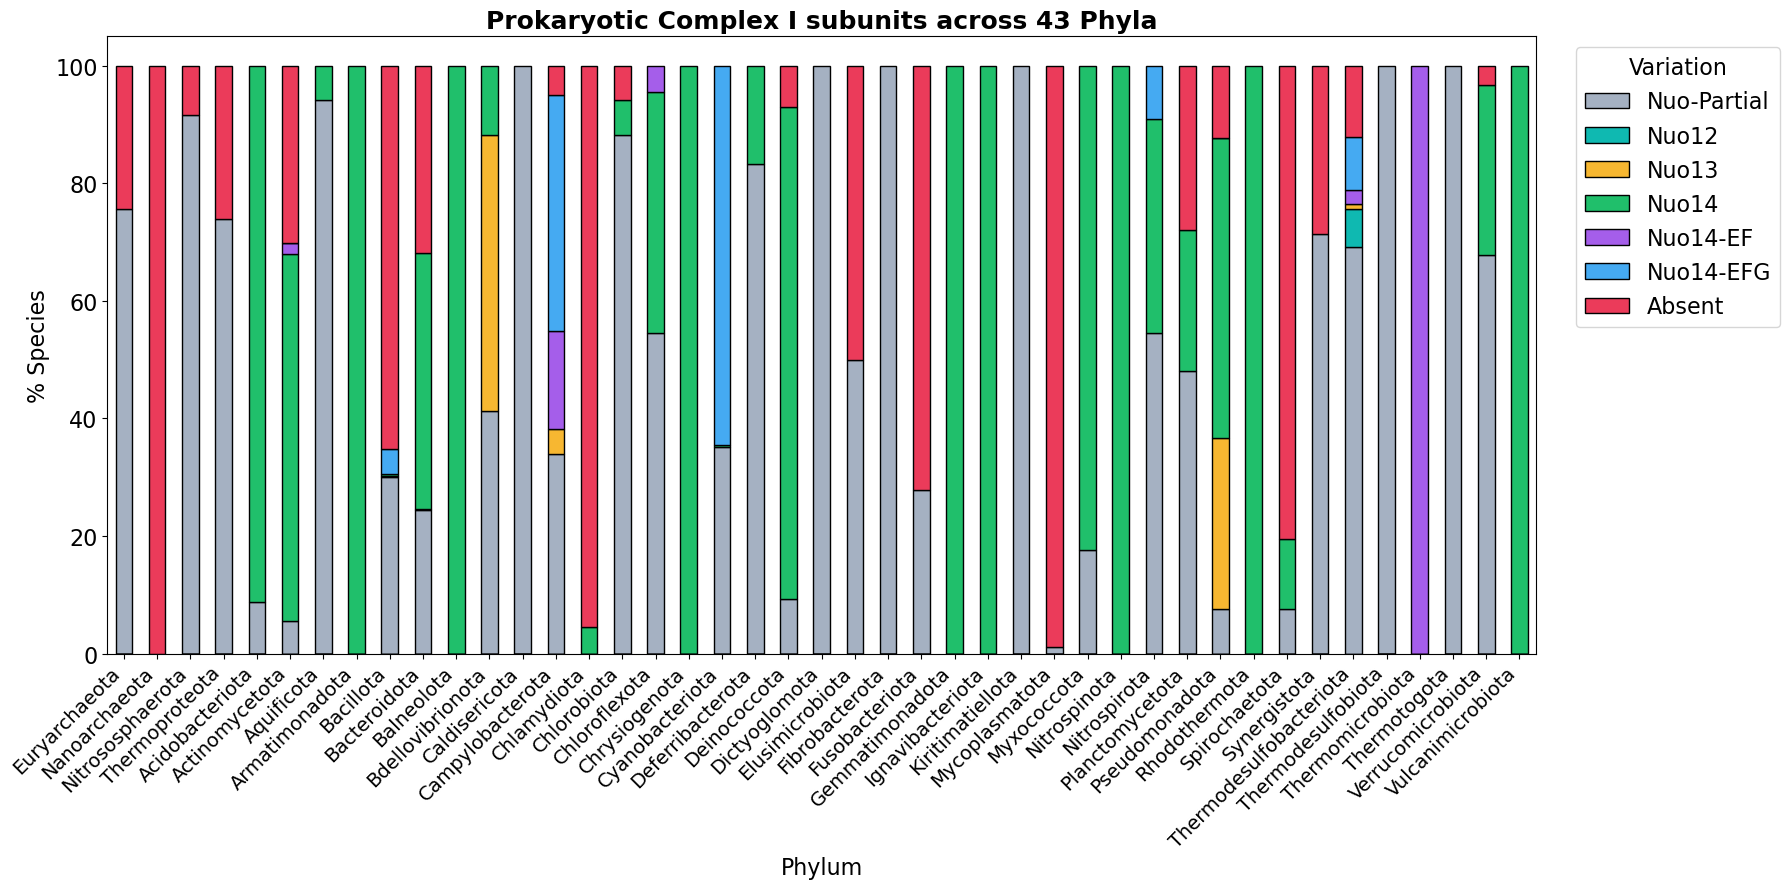

In [43]:
# Normalize the values to percentages (row-wise)
normalized_data = plot_data.set_index("Phylum")
normalized_data_percentage = normalized_data.div(normalized_data.sum(axis=1), axis=0) * 100

# Create the 100% stacked bar plot
plt.figure(figsize=(18, 9))
ax = normalized_data_percentage.plot(
    kind="bar",
    stacked=True,
    color=[complex_colors.get(variation, "#cccccc") for variation in normalized_data_percentage.columns],
    edgecolor="black",
    figsize=(18, 9)
)

# Add plot labels and legend
plt.title("Prokaryotic Complex I subunits across 43 Phyla", fontsize=18, weight='bold')
plt.ylabel("% Species", fontsize=16)
plt.xlabel("Phylum", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=16)

# Customize legend placement and appearance
plt.legend(
    title="Variation",
    bbox_to_anchor=(1.02, 1),
    loc="best",
    title_fontsize=16,
    fontsize=16
)

plt.tight_layout()
# plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/Psorted_datas/phyla_dist_updated_all_variation.psorted_data', bbox_inches='tight', format='Psorted_data', dpi=500)
# Display plot
plt.show()

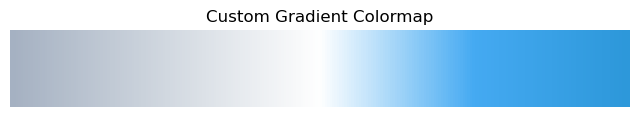

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom colors for the gradient
custom_colors = ["#a5b1c2", "#d1d8e0", '#ffff', "#45aaf2", "#2d98da"]  # Red → Yellow → Green → Blue → Purple

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
ax.set_axis_off()
plt.title("Custom Gradient Colormap")
plt.show()


Chi-Square Test Results:
Chi-Square Statistic: 1122.13
Degrees of Freedom: 12
P-Value: 1.004e-232


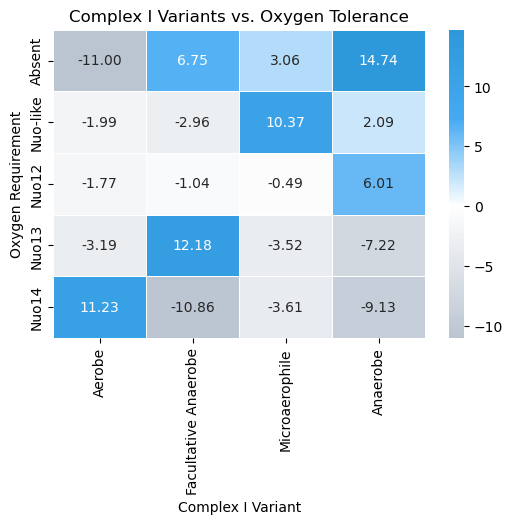

In [45]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load the dataset
file_path = '/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/04-Oxygen-Tolerance/nuo_oxygen_wt_partial.csv'  # Update this path if necessary
data = pd.read_csv(file_path)

data = data[data['Oxygen Requirement']!='Facultative Aerobe']

# Creating a pivot table for Complex I variants vs. Oxygen Requirement
complex_variant_distribution = data.groupby(["Oxygen Requirement", "Variation"]).size().unstack().fillna(0)

# Performing Chi-Square test of independence for the entire variation dataset
chi2_variants, p_variants, dof_variants, expected_variants = stats.chi2_contingency(complex_variant_distribution)

# Calculating standardized residuals
observed_variants = complex_variant_distribution.to_numpy()
standardized_residuals_variants = (observed_variants - expected_variants) / (expected_variants ** 0.5)

# Converting residuals to a dataframe for visualization
residuals_variants_df = pd.DataFrame(standardized_residuals_variants, 
                                     index=complex_variant_distribution.index, 
                                     columns=complex_variant_distribution.columns)

# Displaying Chi-Square test results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_variants:.2f}")
print(f"Degrees of Freedom: {dof_variants}")
print(f"P-Value: {p_variants:.3e}")

# Plotting heatmap of standardized residuals with annotations
plt.figure(figsize=(6, 4))
# Reset index to bring "Oxygen Requirement" into the columns
residuals_variants_df = residuals_variants_df.reset_index()

# Transpose the dataframe correctly
residuals_transposed = residuals_variants_df.set_index("Oxygen Requirement").T
residuals_transposed = residuals_transposed[['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']]
sns.heatmap(residuals_transposed, annot=True, cmap=custom_cmap, center=0, linewidths=0.5, fmt=".2f")

# Labels and title
plt.title("Complex I Variants vs. Oxygen Tolerance")
plt.xlabel("Complex I Variant")
plt.ylabel("Oxygen Requirement")
plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/oxygen_residuals_heatmaps.pdf', bbox_inches='tight', format='pdf', dpi=500)
plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/oxygen_residuals_heatmaps.png', bbox_inches='tight', dpi=500)
# Display the plot
plt.show()


In [46]:
residuals_variants_df.columns


Index(['Oxygen Requirement', 'Absent', 'Nuo-like', 'Nuo12', 'Nuo13', 'Nuo14'], dtype='object', name='Variation')

In [47]:
complex_variant_distribution.T

Oxygen Requirement,Aerobe,Anaerobe,Facultative Anaerobe,Microaerophile
Variation,,,,
Absent,481.0,312.0,387.0,84.0
Nuo-like,79.0,26.0,17.0,36.0
Nuo12,0.0,5.0,0.0,0.0
Nuo13,263.0,2.0,240.0,7.0
Nuo14,1590.0,78.0,196.0,57.0


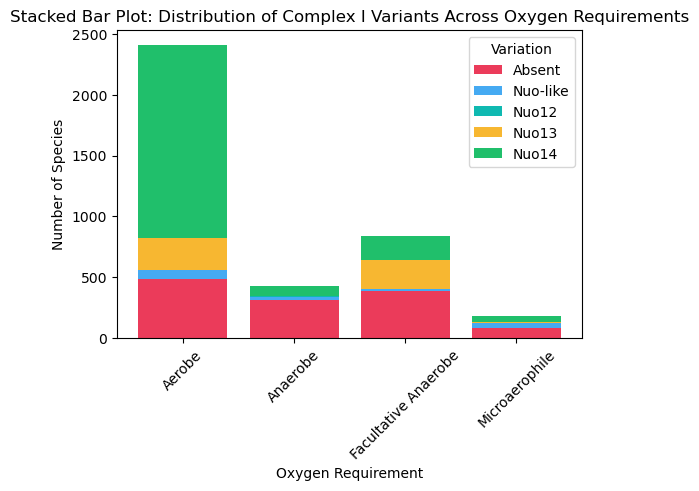

In [48]:
df = complex_variant_distribution.reset_index()

# Defining colors based on the provided color scheme
colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584', "#eb3b5a"]
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo-like', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation', 'Absent']

# Creating a color mapping for the variants in the dataset
complex_colors = dict(zip(labels, colors))

# Assign colors to existing variants in the dataset
variant_colors = [complex_colors.get(variant, "#808080") for variant in df.columns[1:]]  # Default to gray if not found

# Creating a stacked bar plot with custom colors
fig, ax = plt.subplots(figsize=(6, 4))

# Stacking bars
bottom_values = np.zeros(len(df["Oxygen Requirement"]))

# Plot each variation as a stacked bar with the assigned colors
for i, (variant, color) in enumerate(zip(df.columns[1:], variant_colors)):
    ax.bar(df["Oxygen Requirement"], df[variant], color=color, label=variant, bottom=bottom_values)
    bottom_values += df[variant]  # Update bottom for stacking

# Labels and title
ax.set_xlabel("Oxygen Requirement")
ax.set_ylabel("Number of Species")
ax.set_title("Stacked Bar Plot: Distribution of Complex I Variants Across Oxygen Requirements")
ax.legend(title="Variation", loc="upper right")

plt.xticks(rotation=45)
plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/oxygen_species.pdf', bbox_inches='tight', format='pdf', dpi=500)
plt.show()


## Analysis of Complex I Variants vs. Oxygen Requirement

Each cell’s numeric value indicates how many more (positive) or fewer (negative) species there are in that category than expected if there were no relationship.

---

### 1. Aerobes

- **Absent**: Very negative (−11.01)  
  - This means there are far **fewer** Aerobes that lack Complex I than expected.  
  - **Interpretation**: Aerobes nearly always have some Complex I variant.

- **Nuo14**: Strongly positive (+11.23)  
  - This means there are many more Aerobes with Nuo14 than expected.  
  - **Interpretation**: Aerobes are **strongly associated** with Nuo14.

Overall, Aerobes typically possess **Nuo14** and rarely fall under the “Absent” category.

---

### 2. Anaerobes

- **Absent**: Very positive (+14.73)  
  - Many more Anaerobes lack Complex I than expected.  

- **Nuo12**: Moderately positive (+6.03)  
  - More Anaerobes have Nuo12 than expected.

- **Nuo13** and **Nuo14**: Both strongly negative (−7.22, −9.13)  
  - Anaerobes rarely have these variants.

**Summary**: Anaerobes tend to **lack** Complex I entirely or, if they do have it, **Nuo12** is the favored variant.

---

### 3. Facultative Aerobes

- **All residuals near zero** (e.g., +0.19, +0.56, −0.13, −0.63, +0.01)  
  - No strong preference for any Complex I variant.  
  - **Interpretation**: Facultative Aerobes roughly match the expected counts under a scenario of no association.

Hence, Facultative Aerobes do not show a notable bias in Complex I usage.

---

### 4. Facultative Anaerobes

- **Absent**: Moderately positive (+6.74)  
  - More Facultative Anaerobes lack Complex I than expected.
  
- **Nuo13**: Very positive (+12.21)  
  - Far more Facultative Anaerobes have Nuo13 than expected.

- **Nuo14**: Very negative (−10.86)  
  - Facultative Anaerobes rarely have Nuo14.

Therefore, Facultative Anaerobes typically **lack** Complex I or rely on **Nuo13**, but almost never carry Nuo14.

---

### 5. Microaerophiles

- **Absent**: Slightly positive (+3.06)  
  - Slightly more Microaerophiles lack Complex I.  

- **Nuo‐like**: Strongly positive (+10.35)  
  - Many more Microaerophiles have the “Nuo‐like” variant than expected.

- **Nuo13** and **Nuo14**: Both mildly negative (about −3.5 each)  
  - Microaerophiles do not favor Nuo13 or Nuo14.

Thus, Microaerophiles tend to be **either absent** of Complex I or use a **“Nuo‐like”** variant.

---

## Key Observations

- **Aerobes**: Strongly associated with **Nuo14**, rarely “Absent”.  
- **Anaerobes**: Often **Absent** or **Nuo12**; rarely Nuo13/Nuo14.  
- **Facultative Aerobes**: No strong preference (near‐zero residuals).  
- **Facultative Anaerobes**: Commonly **Absent** or **Nuo13**, rarely Nuo14.  
- **Microaerophiles**: Often **Absent** or **Nuo‐like**; not typically Nuo13/Nuo14.

Overall, these patterns suggest that each organism’s oxygen requirement correlates with whether (and which) Complex I variant is present, likely reflecting different adaptations for oxygen handling and energy generation.


In [49]:
data['Variation'].value_counts()

Variation
Nuo14       1921
Absent      1264
Nuo13        512
Nuo-like     158
Nuo12          5
Name: count, dtype: int64

In [50]:
complex_variant_distribution.reset_index()['Oxygen Requirement'].values.tolist()

['Aerobe', 'Anaerobe', 'Facultative Anaerobe', 'Microaerophile']

In [51]:
['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']

['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']

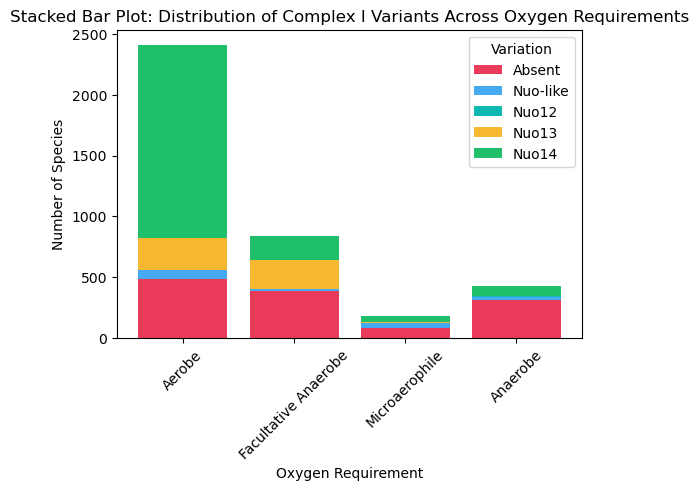

In [52]:
# Reorder the dataframe based on the desired order
desired_order = ['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']
df = df.set_index("Oxygen Requirement").loc[desired_order].reset_index()

# Creating a stacked bar plot with custom colors and correct order
fig, ax = plt.subplots(figsize=(6, 4))

# Stacking bars
bottom_values = np.zeros(len(df["Oxygen Requirement"]))

# Plot each variation as a stacked bar with the assigned colors
for i, (variant, color) in enumerate(zip(df.columns[1:], variant_colors)):
    ax.bar(df["Oxygen Requirement"], df[variant], color=color, label=variant, bottom=bottom_values)
    bottom_values += df[variant]  # Update bottom for stacking

# Labels and title
ax.set_xlabel("Oxygen Requirement")
ax.set_ylabel("Number of Species")
ax.set_title("Stacked Bar Plot: Distribution of Complex I Variants Across Oxygen Requirements")
ax.legend(title="Variation", loc="upper right")

plt.xticks(rotation=45)
plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/oxygen_species.pdf', bbox_inches='tight', format='pdf', dpi=500)
plt.show()


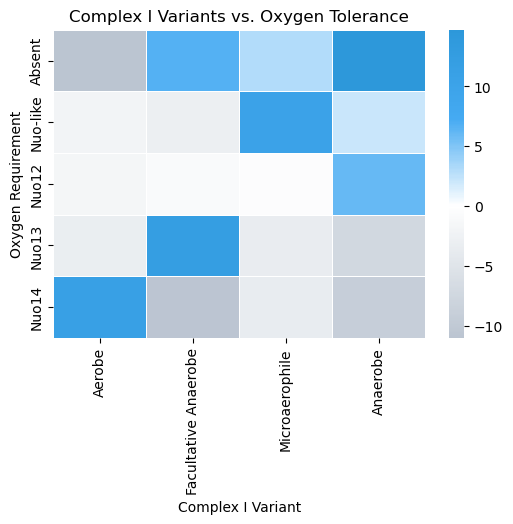

In [53]:
plt.figure(figsize=(6, 4))
sns.heatmap(residuals_transposed, annot=False, cmap=custom_cmap, center=0, linewidths=0.5, fmt=".2f")

# Labels and title
plt.title("Complex I Variants vs. Oxygen Tolerance")
plt.xlabel("Complex I Variant")
plt.ylabel("Oxygen Requirement")
plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/oxygen_residuals_heatmaps_no_annotation.pdf', bbox_inches='tight', format='pdf', dpi=500)
# plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/oxygen_residuals_heatmaps.png', bbox_inches='tight', dpi=500)
# Display the plot
plt.show()

In [54]:
motility = pd.read_csv('/Users/akshayonly/Work/04-Complex-I/Data/02-Genomic-Records-and-Metadata/07-BACDIVE/Processed/Motility.csv')

In [55]:
motility['Motility'] = motility['Motility'].map({1: 'Motile', 0: 'Non-Motile'})

In [56]:
motility

,Species,Motility
0,Abiotrophia defectiva,Non-Motile
1,Absicoccus porci,Non-Motile
2,Abyssibacter profundi,Motile
3,Vallitalea guaymasensis,Motile
4,Acanthopleuribacter pedis,Motile
...,...,...
9967,Zunongwangia endophytica,Non-Motile
9968,Zunongwangia mangrovi,Non-Motile
9969,Zunongwangia profunda,Non-Motile
9970,Zymomonas mobilis,Non-Motile


In [57]:
motility = nuo_bool_final[['Species', 'Variation']].merge(motility)
motility = motility[motility['Variation']!='Nuo-Partial'].drop_duplicates()

In [58]:
# # Creating a pivot table for Complex I variants vs. Motility
# complex_variant_distribution = motility.groupby(["Motility", "Variation"]).size().unstack().fillna(0)

# # Performing Chi-Square test of independence for the entire variation dataset
# chi2_variants, p_variants, dof_variants, expected_variants = stats.chi2_contingency(complex_variant_distribution)

# # Calculating standardized residuals
# observed_variants = complex_variant_distribution.to_numpy()
# standardized_residuals_variants = (observed_variants - expected_variants) / (expected_variants ** 0.5)

# # Converting residuals to a dataframe for visualization
# residuals_variants_df = pd.DataFrame(standardized_residuals_variants, 
#                                      index=complex_variant_distribution.index, 
#                                      columns=complex_variant_distribution.columns)

# # Displaying Chi-Square test results
# print("Chi-Square Test Results:")
# print(f"Chi-Square Statistic: {chi2_variants:.2f}")
# print(f"Degrees of Freedom: {dof_variants}")
# print(f"P-Value: {p_variants:.3e}")

# # Plotting heatmap of standardized residuals with annotations
# plt.figure(figsize=(6, 4))
# sns.heatmap(residuals_variants_df, annot=True, cmap=["#ffb142", "#ecf0f1", "#34ace0"], center=0, linewidths=0.5, fmt=".2f")

# # Labels and title
# plt.title("Complex I Variants vs. Motility")
# plt.xlabel("Complex I Variant")
# plt.ylabel("Motility")

# Archaea Distribution

In [59]:
def plot_nuo_subunits_grid_(df, class_column, subunit_columns, subunits_order, subunits_colors, cols=3, label='archaea'):
    """
    Creates a grid of subplots for each class showing the distribution of Nuo subunits,
    following a specified order and color scheme, with individual x and y axes,
    and only absolute y-axis ticks (no floating values).

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    class_column (str): Column name for the class/grouping variable.
    subunit_columns (list): List of column names corresponding to Nuo subunits.
    subunits_order (list): Ordered list of subunit names for consistent plotting.
    subunits_colors (dict): Dictionary mapping subunit names to specific colors.
    cols (int): Number of columns in the grid layout (default: 3).
    """
    classes = df[class_column].unique()
    num_classes = len(classes)
    rows = math.ceil(num_classes / cols)  # Calculate number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten in case of a 2D array

    for i, class_name in enumerate(classes):
        class_data = df[df[class_column] == class_name][subunit_columns].sum()
        no_species = df[(df['Class']==class_name)]['Species'].nunique()
        # phyla = df[(df['Class']==class_name)]['Phylum'].unique()[0]
        filtered_df = df[df['Class'] == class_name]
        if not filtered_df.empty:
            phyla = filtered_df['Phylum'].unique()[0]
        else:
            phyla = "Unknown"        
        
        # Ensure correct order and assign colors
        class_data = class_data.reindex(subunits_order)
        colors = [subunits_colors[subunit] for subunit in subunits_order]

        axes[i].bar(class_data.index, class_data.values, color=colors)
        axes[i].set_title(f"{phyla}: {class_name}\n(n={no_species})", fontsize=10)
        axes[i].set_ylabel("Number of Species")
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].set_xticks(range(len(subunits_order)))
        axes[i].set_xticklabels(subunits_order, rotation=90)

        # Set absolute y-axis ticks (no floating values)
        y_max = class_data.max()
        axes[i].set_yticks(range(0, int(y_max) + 1, max(1, int(y_max / 5))))

    # Hide empty subplots if classes < grid slots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PDFs/{label}_dist_grid.pdf', bbox_inches='tight', format='pdf', dpi=500)
    plt.savefig(f'/Users/akshayonly/Work/04-Complex-I/Data/07-Figures/PNGs/{label}_dist_grid.png', bbox_inches='tight', dpi=500)
    plt.show()

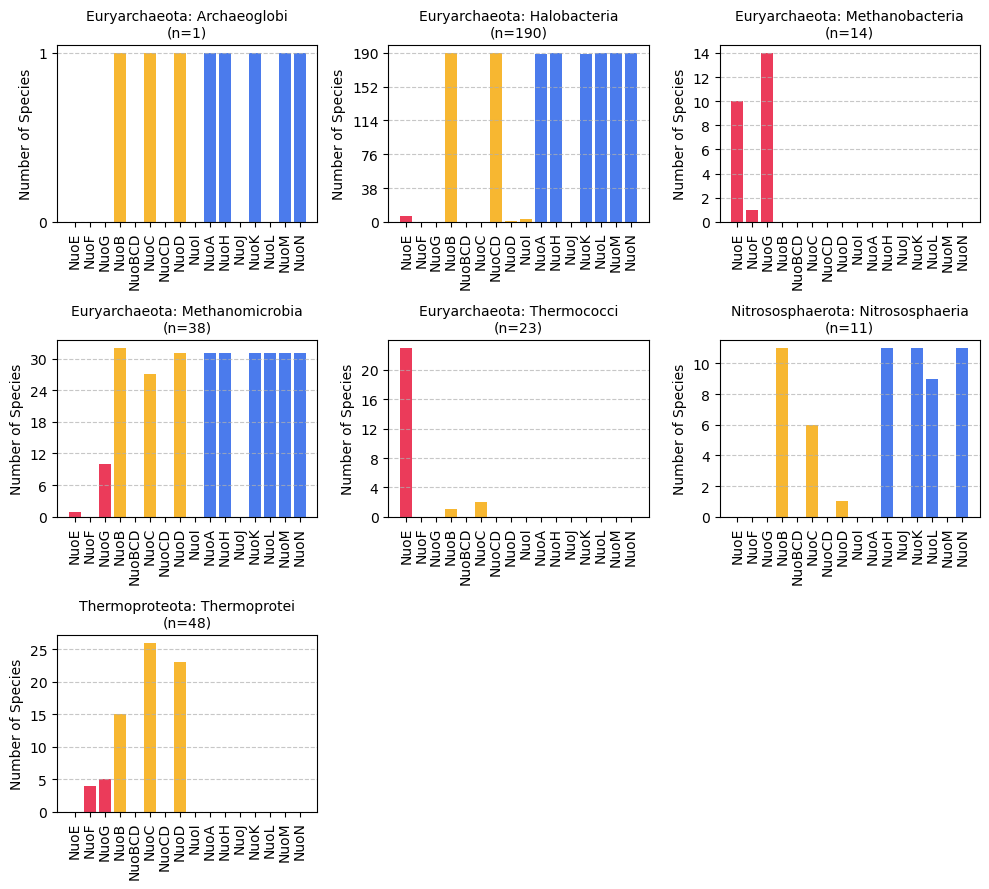

In [60]:
subunits_colors = {
    'NuoE': '#eb3b5a', 'NuoF': '#eb3b5a', 'NuoG': '#eb3b5a',
    'NuoB': '#f7b731', 'NuoBCD': '#f7b731', 'NuoC': '#f7b731',
    'NuoCD': '#f7b731', 'NuoD': '#f7b731', 'NuoI': '#f7b731',
    'NuoA': '#4b7bec', 'NuoH': '#4b7bec', 'NuoJ': '#4b7bec',
    'NuoK': '#4b7bec', 'NuoL': '#4b7bec', 'NuoM': '#4b7bec',
    'NuoN': '#4b7bec'
}

subunits_order = [
    'NuoE', 'NuoF', 'NuoG', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 
    'NuoD', 'NuoI', 'NuoA', 'NuoH', 'NuoJ', 'NuoK', 'NuoL', 
    'NuoM', 'NuoN'
]

archaea_data = nuo_bool_final[(nuo_bool_final['Organism']=='Archaea')]
archaea_data.sort_values(['Phylum', 'Class'], inplace=True)

selected_cols = ['Phylum', 'Class', 'Species', 'NuoA', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN', 'Variation']
archaea_data_nr = archaea_data[selected_cols].drop_duplicates('Species')

plot_nuo_subunits_grid_(archaea_data_nr, 'Class', archaea_data_nr.columns[3:-1].tolist(), subunits_order, subunits_colors, cols=3)

In [61]:
# bacteria_data = nuo_bool_final[(nuo_bool_final['Organism']=='Bacteria')]
# bacteria_data.sort_values(['Phylum', 'Class'], inplace=True)

# selected_cols = ['Phylum', 'Class', 'Species', 'NuoA', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN', 'Variation']
# bacteria_data_nr = bacteria_data[selected_cols].drop_duplicates('Species')

# plot_nuo_subunits_grid_(bacteria_data_nr, 'Class', bacteria_data_nr.columns[3:-1].tolist(), subunits_order, subunits_colors, cols=3, label='bacteria')

## Archaea: Halobacterium salinarum

In [62]:
nuo_bool_final[(nuo_bool_final['Organism']=='Archaea')]['Phylum'].value_counts()

Phylum
Euryarchaeota       351
Thermoproteota       98
Nitrososphaerota     17
Name: count, dtype: int64

In [63]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Euryarchaeota')]['Class'].value_counts()

Class
Halobacteria       244
Methanomicrobia     62
Thermococci         26
Methanobacteria     18
Archaeoglobi         1
Name: count, dtype: int64

In [64]:
nuo_bool_final[(nuo_bool_final['Class']=='Methanomicrobia')]['Species'].value_counts()

Species
Methanosarcina mazei                    12
Methanosarcina barkeri                   5
Methanothrix sp.                         4
Methanosarcina siciliae                  3
uncultured Methanolobus sp.              3
Methanosarcina thermophila               2
Methanospirillum hungatei                2
Methanohalophilus mahii                  1
Methanosarcina flavescens                1
Methanosarcina sp. WH1                   1
Methanocella arvoryzae                   1
Methanospirillum sp. J.3.6.1-F.2.7.3     1
Methanosarcina sp. WWM596                1
Methanosarcina sp. MTP4                  1
Methanococcoides methylutens             1
Methanolobus sediminis                   1
Methanolobus mangrovi                    1
Methanococcoides orientis                1
Methanofollis formosanus                 1
Methanolobus zinderi                     1
Methanohalophilus portucalensis          1
Methanohalophilus halophilus             1
Methanosarcina horonobensis              1
Met

In [65]:
nuo_bool_final[(nuo_bool_final['Species']=='Halorhabdus utahensis')].iloc[:, 7:-1].sum()

NuoA      1
NuoB      1
NuoBCD    0
NuoC      0
NuoCD     1
NuoD      0
NuoE      1
NuoF      0
NuoG      0
NuoH      1
NuoI      0
NuoJ      0
NuoK      1
NuoL      1
NuoM      1
NuoN      1
dtype: int64

In [66]:
nuo_bool_final[(nuo_bool_final['Species']=='Halorhabdus utahensis')].head()

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
19674,Euryarchaeota,Halobacteria,Halorhabdus utahensis,CP001687.1,GCA_000023945.1_ASM2394v1_genomic.fna,Chromosome,Archaea,True,True,False,...,False,False,True,False,False,True,True,True,True,Nuo-Partial


In [67]:
accession = 'CP006884.1'

In [68]:
nuo_bool_final[(nuo_bool_final['Accession']==accession)].iloc[:, 7:]

,NuoA,NuoB,NuoBCD,NuoC,NuoCD,NuoD,NuoE,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
17966,True,True,False,False,True,False,False,False,False,True,False,False,True,True,True,True,Nuo-Partial


In [69]:
nuohmmer_unfiltered[(nuohmmer_unfiltered['Accession']==accession) & (nuohmmer_unfiltered['Subunit']=='NuoI')]

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster
417889,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_858,2.600000e-07,29.2,7.7,# 811491 # 811820 # 1 # ID=1_858;partial=00;st...,NuoI,85,FinedTuned2,811491,811820,-6.585027,109,1,2
417891,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_1814,4.100000e-07,28.5,24.8,# 1762929 # 1763759 # -1 # ID=1_1814;partial=0...,NuoI,85,FinedTuned2,1762929,1763759,-6.387216,276,-1,4
417893,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_1921,3.300000e-07,28.8,24.1,# 1868583 # 1870718 # -1 # ID=1_1921;partial=0...,NuoI,85,FinedTuned2,1868583,1870718,-6.481486,711,-1,5
417899,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_2031,2.500000e-35,120.5,4.4,# 1978006 # 1978467 # 1 # ID=1_2031;partial=00...,NuoI,85,FinedTuned2,1978006,1978467,-34.602060,153,1,7


In [70]:
nuohmmer_unfiltered[(nuohmmer_unfiltered['Accession']==accession) & (nuohmmer_unfiltered['Subunit']=='NuoJ')]

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster
417900,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_2032,6.800000e-21,72.9,11.9,# 1978761 # 1979030 # 1 # ID=1_2032;partial=00...,NuoJ,85,FinedTuned2,1978761,1979030,-20.167491,89,1,8
417901,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_2033,1.800000e-09,35.5,0.1,# 1979027 # 1979425 # 1 # ID=1_2033;partial=00...,NuoJ,85,FinedTuned2,1979027,1979425,-8.744727,132,1,8


In [71]:
nuo_bool_final[nuo_bool_final['Species']=='Rhodobacter sphaeroides']

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation


In [72]:
taxonomy[taxonomy['Species']=='Rhodobacter sphaeroides']

,TaxID,Organism,Lineage,LineageTaxIDs,Superkingdom,Phylum,Class,Order,Family,Genus,Species,Strain


In [73]:
archaea_data['Species'].nunique()

325

In [74]:
taxonomy[taxonomy['Organism']=='Archaea']['Lineage'].nunique()

441

In [75]:
genomes_dataset[genomes_dataset['Organism']=='Archaea']['Species'].nunique()

431

In [76]:
interested_species = []
for species in taxonomy['Species'].unique():
    if "Pyrococcus".lower() in species.lower():
        print(species)
        interested_species.append(species)

Pyrococcus abyssi
Pyrococcus horikoshii
Pyrococcus furiosus
Pyrococcus yayanosii
Pyrococcus sp. NA2
Pyrococcus kukulkanii
Pyrococcus sp. ST04


In [77]:
nuo_bool_final[nuo_bool_final['Species'].isin(interested_species)].head()

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation


In [78]:
phylum_variation_summary['%Species'] = (phylum_variation_summary['TotalSpecies']/11039)*100

In [79]:
phylum_variation_summary.sort_values('%Species', ascending=False).head(10)

,Phylum,TotalSpecies,SearchedSpecies,Nuo-Partial,Nuo12,Nuo13,Nuo14,Nuo14-EF,Nuo14-EFG,Absent,%Species
32,Pseudomonadota,4617,4052,347,0,1343,2362,2,0,565,41.824441
1,Actinomycetota,2144,1499,120,0,0,1339,39,1,645,19.422049
4,Bacillota,1690,588,508,0,1,7,0,72,1102,15.309358
5,Bacteroidota,862,588,211,0,1,376,0,0,274,7.808678
19,Euryarchaeota,352,266,266,0,0,0,0,0,86,3.188695
14,Cyanobacteriota,262,262,92,0,0,1,0,169,0,2.373403
25,Mycoplasmatota,186,2,2,0,0,0,0,0,184,1.684935
9,Campylobacterota,161,153,55,0,7,0,27,65,8,1.458465
36,Thermodesulfobacteriota,123,108,85,8,1,0,3,11,15,1.114231
34,Spirochaetota,118,23,9,0,0,14,0,0,95,1.068937


In [80]:
genomes_dataset[genomes_dataset['Organism']=='Bacteria']['Species'].nunique()

10608

In [81]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Species'].nunique()

108

In [82]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Species'].value_counts()

Species
Geobacter sulfurreducens              8
uncultured Pseudodesulfovibrio sp.    4
uncultured Desulfuromusa sp.          2
Syntrophotalea acetylenica            2
Geomonas nitrogeniifigens             2
                                     ..
Megalodesulfovibrio gigas             1
Maridesulfovibrio hydrothermalis      1
Desulfuromonas sp. DDH964             1
Thermodesulfobacterium sp. TA1        1
Desulfobulbus oralis                  1
Name: count, Length: 108, dtype: int64

In [83]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Variation'].value_counts()

Variation
Nuo-Partial    103
Nuo14-EFG       13
Nuo12           10
Nuo14-EF         4
Nuo13            1
Name: count, dtype: int64

In [84]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]['Class'].unique()

array(['Desulfuromonadia', 'Desulfobacteria', 'Desulfarculia'],
      dtype=object)

In [85]:
species_list = nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]['Species'].unique()

In [86]:
for species in species_list:
    print(species)

Syntrophotalea carbinolica
Desulfonema limicola
Desulfococcus multivorans
Syntrophotalea acetylenica
Desulfosarcina alkanivorans
Syntrophotalea acetylenivorans
Desulfoferula mesophila
uncultured Desulfobacter sp.


In [87]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
16640,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea carbinolica,CP000142.2,GCA_000012885.1_ASM1288v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
19119,Thermodesulfobacteriota,Desulfobacteria,Desulfonema limicola,CP061799.1,GCA_017377355.1_ASM1737735v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
22366,Thermodesulfobacteriota,Desulfobacteria,Desulfococcus multivorans,NZ_CP015381.1,GCF_001854245.1_ASM185424v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
22367,Thermodesulfobacteriota,Desulfobacteria,Desulfococcus multivorans,NZ_CP019913.2,GCF_002009335.2_ASM200933v2_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
24109,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea acetylenica,NZ_CP015518.1,GCF_001887715.1_ASM188771v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
24110,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea acetylenica,NZ_CP015455.1,GCF_001888165.1_ASM188816v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
25335,Thermodesulfobacteriota,Desulfobacteria,Desulfosarcina alkanivorans,NZ_AP021874.1,GCF_009688945.1_ASM968894v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
25843,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea acetylenivorans,NZ_CP015519.1,GCF_001887775.1_ASM188777v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
27064,Thermodesulfobacteriota,Desulfarculia,Desulfoferula mesophila,NZ_AP028679.1,GCF_037076455.1_ASM3707645v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
29028,Thermodesulfobacteriota,Desulfobacteria,uncultured Desulfobacter sp.,OY762229.1,GCA_963665355.1_piMetSpee1.Desulfobacter_sp_1....,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12


## Archaea 420 or N

In [88]:
import os
import re
import pandas as pd
from pathlib import Path

# Define directory
cdhit_results_dir = Path("/Users/akshayonly/Work/04-Complex-I/Data/05-Post-Search/Hits-Sequences/Archaea/CDHit")

# Process all files in the directory
cd_hits = [
    pd.read_csv(result, skiprows=7, sep='\t').assign(
        ProteinAccession=lambda df: df['Query'].apply(lambda x: (m.group(1) if (m := re.search(r'>(\S+)', x)) else None))
    )[['ProteinAccession', 'Short name', 'Superfamily']]
    for result in cdhit_results_dir.iterdir() if result.is_file()
]

# Concatenate all results
cd_hits_df = pd.concat(cd_hits, ignore_index=True)

# Display DataFrame
cd_hits_df.head()

,ProteinAccession,Short name,Superfamily
0,AE004437.1_520,NuoA,cl43295
1,AE008384.1_2567,NuoA,cl43295
2,AE010299.1_1535,NuoA,cl43295
3,AM180088.1_702,NuoA,cl43295
4,AM774415.1_514,NuoA,cl43295


In [89]:
cd_hits_df['Short name'].value_counts()

Short name
NuoK                            448
NuoC                            417
NuoD                            398
NuoN                            293
NuoM                            276
NuoA                            274
nuoB_fam                        256
NuoH                            249
NuoL                            241
F420_dehyd_FpoK                 104
NuoB                             66
F420_dehyd_FpoH                  53
PRK06074                         52
F420_dehyd_FpoD                  51
NuoE                             48
F420_dehyd_FpoC                  45
YjgC                             43
PRK06075                         42
F420_dehyd_FpoL superfamily      31
NuoG superfamily                 28
PRK05715                         28
F420_dehyd_FpoL                  16
HycG                             13
NuoF superfamily                 10
Complex1_51K superfamily          8
F420_dehyd_FpoC superfamily       7
NADH_4Fe-4S superfamily           7
PRK13596 superfam

In [90]:
cd_hits_df[cd_hits_df['Short name'].str.startswith('Complex')]

,ProteinAccession,Short name,Superfamily
3525,CP001742.1_617,Complex1_51K superfamily,-
3529,CP001742.1_1396,Complex1_51K superfamily,-
3534,CP003378.1_801,Complex1_51K superfamily,-
3539,CP003378.1_1165,Complex1_51K superfamily,-
3543,FN869859.1_1251,Complex1_51K superfamily,-
3551,NZ_AP027738.1_906,Complex1_51K superfamily,-
3559,NZ_CP010515.1_752,Complex1_51K superfamily,-
3564,NZ_CP010515.1_840,Complex1_51K superfamily,-


In [91]:
nuohmmer_filtered.columns

Index(['Accession', 'Replicon', 'GenomeFile', 'SequenceLength(Mb)',
       'ProteomeFile', 'ProteinAccession', 'evalue', 'BitScore', 'Bias',
       'SequenceDesc', 'Subunit', 'SeqsClustThreshold', 'HMMParameter',
       'Start', 'End', 'log10evalue', 'EstProtLength', 'Strand', 'Cluster'],
      dtype='object')

In [92]:
cd_hits_df = cd_hits_df.merge(nuohmmer_filtered[['Accession', 'ProteinAccession', 'Subunit', 'EstProtLength', 'BitScore', 'log10evalue']]).merge(nuo_bool_final[['Accession', 'Species', 'Phylum', 'Class']])

In [93]:
cd_hits_df[cd_hits_df['Short name'].str.startswith('Nuo')]['Species'].nunique()

297

In [94]:
cd_hits_df[cd_hits_df['Short name'].str.startswith('Nuo')]['Class'].nunique()

7

In [95]:
cd_hits_df[cd_hits_df['Short name'].str.startswith('Nuo')]['Subunit'].value_counts()

Subunit
NuoCD    782
NuoK     448
NuoN     293
NuoM     276
NuoA     274
NuoH     249
NuoL     241
NuoB      66
NuoE      47
NuoG      29
NuoC      24
NuoF      18
NuoD       9
Name: count, dtype: int64

In [96]:
cd_hits_df[cd_hits_df['Short name'].str.startswith('Nuo')]['Class'].value_counts()

Class
Halobacteria       2321
Methanomicrobia     207
Nitrososphaeria     117
Thermoprotei         51
Methanobacteria      27
Thermococci          26
Archaeoglobi          7
Name: count, dtype: int64

In [97]:
cd_hits_df[cd_hits_df['Short name'].str.startswith('F420')]['Species'].nunique()

31

In [98]:
cd_hits_df[(cd_hits_df['Short name'].str.startswith('Nuo')) & (cd_hits_df['Species']=='Methanosarcina mazei')]

,ProteinAccession,Short name,Superfamily,Accession,Subunit,EstProtLength,BitScore,log10evalue,Species,Phylum,Class
1,AE008384.1_2567,NuoA,cl43295,AE008384.1,NuoA,124,132.9,-38.619789,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
5,AP019780.1_1285,NuoA,cl43295,AP019780.1,NuoA,124,132.9,-38.568636,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
32,CP004144.1_2363,NuoA,cl43295,CP004144.1,NuoA,124,132.9,-38.657577,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
47,CP009509.1_2322,NuoA,cl43295,CP009509.1,NuoA,124,132.9,-38.619789,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
48,CP009511.1_2268,NuoA,cl43295,CP009511.1,NuoA,124,132.9,-38.619789,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
49,CP009512.1_2368,NuoA,cl43295,CP009512.1,NuoA,124,132.9,-38.602060,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
50,CP009513.1_3084,NuoA,cl43295,CP009513.1,NuoA,124,132.9,-38.602060,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
51,CP009514.1_2369,NuoA,cl43295,CP009514.1,NuoA,124,132.9,-38.602060,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
63,CP042908.1_2452,NuoA,cl43295,CP042908.1,NuoA,124,132.9,-38.585027,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
154,NZ_CP009510.1_2875,NuoA,cl43295,NZ_CP009510.1,NuoA,124,132.9,-38.585027,Methanosarcina mazei,Euryarchaeota,Methanomicrobia


In [99]:
cd_hits_df[(cd_hits_df['Short name'].str.startswith('F420')) & (cd_hits_df['Species']=='Methanosarcina mazei')]['Short name'].value_counts()

Short name
F420_dehyd_FpoK                24
F420_dehyd_FpoH                12
F420_dehyd_FpoD                12
F420_dehyd_FpoL superfamily    12
F420_dehyd_FpoC                12
Name: count, dtype: int64

In [100]:
m_mazei_f420 = set(cd_hits_df[(cd_hits_df['Short name'].str.startswith('F420')) & (cd_hits_df['Species']=='Methanosarcina mazei')]['ProteinAccession'])
m_mazei_nuo = set(cd_hits_df[(cd_hits_df['Short name'].str.startswith('Nuo')) & (cd_hits_df['Species']=='Methanosarcina mazei')]['ProteinAccession'])

In [101]:
m_mazei_nuo.intersection(m_mazei_f420)

set()

In [102]:
cd_hits_df[(cd_hits_df['Short name'].str.startswith('F420'))]['Class'].value_counts()

Class
Methanomicrobia    315
Name: count, dtype: int64

In [103]:
cd_hits_df[(cd_hits_df['Short name'].str.startswith('NuoM'))]['Species'].value_counts()

Species
Methanosarcina mazei        12
Halobacterium salinarum      7
Methanosarcina barkeri       5
Methanothrix sp.             4
Halapricum desulfuricans     4
                            ..
Salarchaeum japonicum        1
Haladaptatus salinisoli      1
Haladaptatus halobius        1
Halobacterium litoreum       1
Natronococcus sp. CG52       1
Name: count, Length: 222, dtype: int64

In [104]:
cd_hits_df[cd_hits_df['Accession']=='CP004144.1'].sort_values('ProteinAccession')

,ProteinAccession,Short name,Superfamily,Accession,Subunit,EstProtLength,BitScore,log10evalue,Species,Phylum,Class
1858,CP004144.1_2351,NuoN,cl43305,CP004144.1,NuoN,493,432.2,-129.130768,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
1392,CP004144.1_2352,NuoM,cl34059,CP004144.1,NuoM,495,468.6,-140.142668,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
2846,CP004144.1_2353,F420_dehyd_FpoL superfamily,-,CP004144.1,NuoL,672,669.3,-200.698970,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
2161,CP004144.1_2354,F420_dehyd_FpoK,cl46229,CP004144.1,NuoK,102,132.2,-38.744727,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
3139,CP004144.1_2354,F420_dehyd_FpoK,cl46229,CP004144.1,NuoK,102,132.2,-38.744727,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
1091,CP004144.1_2358,F420_dehyd_FpoH,cl46232,CP004144.1,NuoH,347,322.0,-95.795880,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
1664,CP004144.1_2359,F420_dehyd_FpoD,cl46234,CP004144.1,NuoD,374,405.4,-121.004365,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
3434,CP004144.1_2360,F420_dehyd_FpoC,cl48906,CP004144.1,NuoC,158,121.5,-34.958607,Methanosarcina mazei,Euryarchaeota,Methanomicrobia
32,CP004144.1_2363,NuoA,cl43295,CP004144.1,NuoA,124,132.9,-38.657577,Methanosarcina mazei,Euryarchaeota,Methanomicrobia


In [105]:
arch_subunits = sorted(cd_hits_df[cd_hits_df['Accession']=='CP004144.1'].sort_values('ProteinAccession')['Short name'].unique())

In [106]:
pivot = cd_hits_df.pivot_table(index=['Accession', ], columns='Short name', aggfunc='size', fill_value=0)

# Reindex to include all subunits from 'all_subunits' with 0s for missing ones
pivot = pivot.reindex(columns=sorted(cd_hits_df[cd_hits_df['Accession']=='CP004144.1'].sort_values('ProteinAccession')['Short name'].unique()), fill_value=0).reset_index()

# Convert the pivot table to a DataFrame
count_table = pd.DataFrame(pivot)

In [107]:
count_table.iloc[:, 1:] = count_table.iloc[:, 1:].ge(1)  

In [108]:
count_table['Total'] = count_table[arch_subunits].sum(axis=1)

In [109]:
count_table['Total'].value_counts()

Total
3    220
0    173
8     30
1     17
7     14
6      7
5      2
2      2
4      1
Name: count, dtype: int64

In [110]:
count_table = nuo_bool_final[['Accession', 'Species', 'Organism', 'Class', 'Phylum']].merge(count_table)

In [111]:
count_table[count_table['Total']==8]['Species'].value_counts()

Species
Methanosarcina mazei           12
Methanosarcina barkeri          5
Methanosarcina siciliae         3
Methanosarcina acetivorans      1
Methanococcoides burtonii       1
Methanosarcina sp. Kolksee      1
Methanosarcina vacuolata        1
Methanosarcina lacustris        1
Methanosarcina horonobensis     1
Methanosarcina flavescens       1
Methanosarcina sp. MTP4         1
Methanosarcina sp. WWM596       1
Methanosarcina sp. WH1          1
Name: count, dtype: int64

In [112]:
count_table[count_table['Total']==8].head()

,Accession,Species,Organism,Class,Phylum,F420_dehyd_FpoC,F420_dehyd_FpoD,F420_dehyd_FpoH,F420_dehyd_FpoK,F420_dehyd_FpoL superfamily,NuoA,NuoM,NuoN,Total
29,NZ_CP008746.1,Methanosarcina barkeri,Archaea,Methanomicrobia,Euryarchaeota,True,True,True,True,True,True,True,True,8
30,CP009517.1,Methanosarcina barkeri,Archaea,Methanomicrobia,Euryarchaeota,True,True,True,True,True,True,True,True,8
31,CP009526.1,Methanosarcina barkeri,Archaea,Methanomicrobia,Euryarchaeota,True,True,True,True,True,True,True,True,8
32,CP009528.1,Methanosarcina barkeri,Archaea,Methanomicrobia,Euryarchaeota,True,True,True,True,True,True,True,True,8
33,CP009530.1,Methanosarcina barkeri,Archaea,Methanomicrobia,Euryarchaeota,True,True,True,True,True,True,True,True,8


In [113]:
genomes_dataset = genomes_dataset.merge(taxonomy[['Species', 'Class', 'Phylum']])

In [114]:
genomes_dataset[genomes_dataset['Class']=='Halobacteria']['Species'].nunique()

190

In [115]:
genomes_dataset[genomes_dataset['Class']=='Methanobacteria']['Species'].nunique()

35

In [116]:
cd_hits_df[cd_hits_df['Class']=='Methanobacteria']['Short name'].value_counts()

Short name
YjgC                            22
NuoG superfamily                13
NuoE                            11
PRK07569 superfamily             3
2Fe-2S_thioredx                  3
NuoF superfamily                 2
NuoG                             1
COG3411                          1
PRK11278 superfamily             1
Complex1_51K superfamily         1
COG3411 superfamily              1
Thioredoxin_like superfamily     1
PRK05035 superfamily             1
2Fe-2S_thioredx superfamily      1
Name: count, dtype: int64

In [117]:
cd_hits_df[(cd_hits_df['Class']=='Methanobacteria') & (cd_hits_df['Short name']=='NuoG superfamily')]

,ProteinAccession,Short name,Superfamily,Accession,Subunit,EstProtLength,BitScore,log10evalue,Species,Phylum,Class
1747,AE000666.1_1515,NuoG superfamily,-,AE000666.1,NuoG,884,396.4,-118.236572,Methanothermobacter thermautotrophicus,Euryarchaeota,Methanobacteria
1750,AP011952.1_1437,NuoG superfamily,-,AP011952.1,NuoG,884,381.9,-113.886057,Methanothermobacter sp. CaT2,Euryarchaeota,Methanobacteria
1753,AP025698.1_1535,NuoG superfamily,-,AP025698.1,NuoG,884,354.6,-105.638272,Methanothermobacter tenebrarum,Euryarchaeota,Methanobacteria
1757,CP001710.1_135,NuoG superfamily,-,CP001710.1,NuoG,887,369.4,-110.096910,Methanothermobacter marburgensis,Euryarchaeota,Methanobacteria
1792,LT608329.1_92,NuoG superfamily,-,LT608329.1,NuoG,613,272.7,-80.853872,Methanothermobacter wolfeii,Euryarchaeota,Methanobacteria
1795,NZ_AP018336.1_1474,NuoG superfamily,-,NZ_AP018336.1,NuoG,884,378.5,-112.823909,Methanothermobacter sp. EMTCatA1,Euryarchaeota,Methanobacteria
1799,NZ_AP027739.1_797,NuoG superfamily,-,NZ_AP027739.1,NuoG,892,395.7,-117.853872,Methanobacterium petrolearium,Euryarchaeota,Methanobacteria
1803,NZ_CP042937.1_777,NuoG superfamily,-,NZ_CP042937.1,NuoG,887,373.9,-111.443697,Methanothermobacter sp. KEPCO-1,Euryarchaeota,Methanobacteria
1805,NZ_CP043480.1_1102,NuoG superfamily,-,NZ_CP043480.1,NuoG,887,369.2,-110.013228,Methanothermobacter sp. THM-2,Euryarchaeota,Methanobacteria
1810,NZ_CP064324.1_1468,NuoG superfamily,-,NZ_CP064324.1,NuoG,884,396.4,-118.251812,Methanothermobacter thermautotrophicus,Euryarchaeota,Methanobacteria


In [118]:
cd_hits_df[(cd_hits_df['Class']=='Methanobacteria') & (cd_hits_df['Short name']=='NuoF superfamily')]

,ProteinAccession,Short name,Superfamily,Accession,Subunit,EstProtLength,BitScore,log10evalue,Species,Phylum,Class
2124,NZ_AP027738.1_906,NuoF superfamily,-,NZ_AP027738.1,NuoF,338,263.6,-78.0,Methanobacterium ferruginis,Euryarchaeota,Methanobacteria
3549,NZ_AP027738.1_906,NuoF superfamily,-,NZ_AP027738.1,NuoF,338,263.6,-78.0,Methanobacterium ferruginis,Euryarchaeota,Methanobacteria


In [119]:
subunit = 'NuoL'

In [120]:
cd_hits_df[cd_hits_df['Subunit']==subunit]['Class'].value_counts()

Class
Halobacteria       221
Methanomicrobia     54
Nitrososphaeria     15
Name: count, dtype: int64

In [121]:
cd_hits_df[cd_hits_df['Short name']==subunit]['Class'].value_counts()

Class
Halobacteria       219
Nitrososphaeria     15
Methanomicrobia      7
Name: count, dtype: int64

Text(0.5, 1.0, 'NuoL subunits hits')

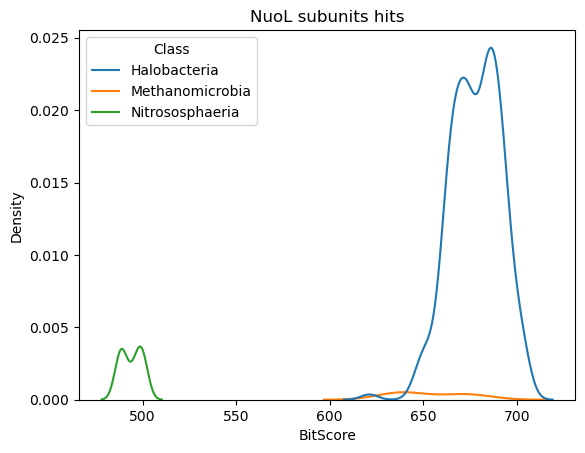

In [122]:
arch_kde = cd_hits_df[cd_hits_df['Short name']==subunit]
sns.kdeplot(data=arch_kde, x='BitScore', hue='Class')
plt.title(f"{subunit} subunits hits")

Text(0.5, 1.0, 'NuoL subunits hits')

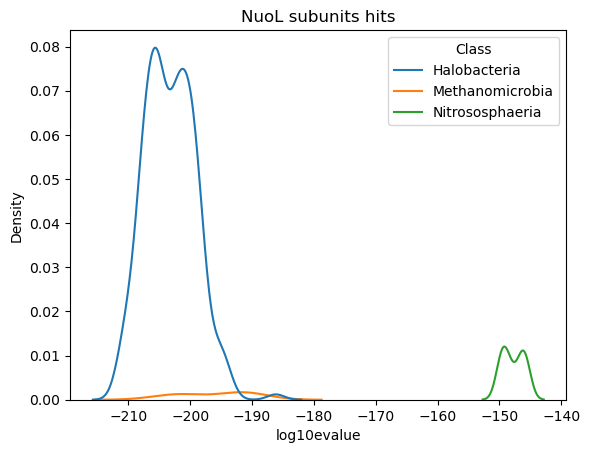

In [123]:
sns.kdeplot(data=arch_kde, x='log10evalue', hue='Class')
plt.title(f"{subunit} subunits hits")

Text(0.5, 1.0, 'NuoL subunits hits')

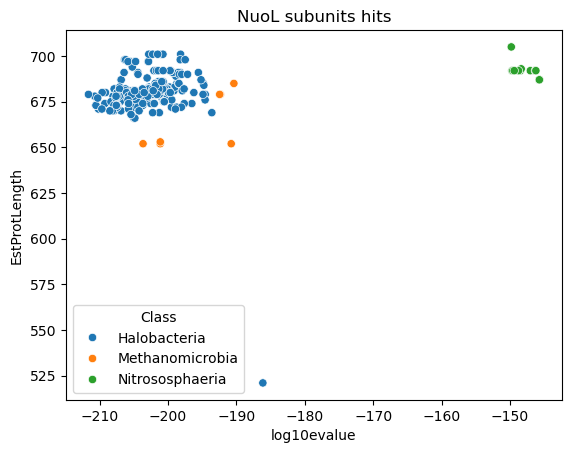

In [124]:
sns.scatterplot(data=arch_kde, x='log10evalue', y='EstProtLength', hue='Class')
plt.title(f"{subunit} subunits hits")

In [125]:
arch_kde[['ProteinAccession', 'Short name', 'Subunit', 'EstProtLength', 'BitScore']]

,ProteinAccession,Short name,Subunit,EstProtLength,BitScore
2813,AE004437.1_528,NuoL,NuoL,692,665.6
2816,AM180088.1_712,NuoL,NuoL,674,675.3
2817,AM774415.1_522,NuoL,NuoL,692,665.6
2819,AY596297.1_1340,NuoL,NuoL,697,685.9
2821,CP000477.1_1105,NuoL,NuoL,652,635.6
...,...,...,...,...,...
3095,OY730264.1_1340,NuoL,NuoL,692,489.2
3096,OY734802.1_697,NuoL,NuoL,692,497.6
3097,OY759726.1_1274,NuoL,NuoL,692,499.0
3098,OY760069.1_1609,NuoL,NuoL,705,500.9


In [126]:
bacteria_accessions = nuo_bool_final[nuo_bool_final['Organism']=='Bacteria']['Accession'].unique()

In [127]:
nuohmmer_filtered[nuohmmer_filtered['Accession'].isin(bacteria_accessions)]

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster
0,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,GCA_016755935.1_ASM1675593v1_cds_proteins.faa,AP024266.1_4302,2.400000e-49,166.0,1.9,# 4565910 # 4566389 # 1 # ID=1_4302;partial=00...,NuoA,85,FinedTuned2,4565910,4566389,-48.619789,159,1,8
1,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,GCA_016755935.1_ASM1675593v1_cds_proteins.faa,AP024266.1_4303,8.000000e-81,270.0,0.1,# 4566398 # 4566952 # 1 # ID=1_4303;partial=00...,NuoB,85,FinedTuned2,4566398,4566952,-80.096910,184,1,8
2,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,GCA_016755935.1_ASM1675593v1_cds_proteins.faa,AP024266.1_4304,9.300000e-70,233.5,0.2,# 4566949 # 4567656 # 1 # ID=1_4304;partial=00...,NuoC,85,FinedTuned2,4566949,4567656,-69.031517,235,1,8
3,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,GCA_016755935.1_ASM1675593v1_cds_proteins.faa,AP024266.1_4305,5.100000e-175,581.7,0.0,# 4567656 # 4568981 # 1 # ID=1_4305;partial=00...,NuoD,85,FinedTuned2,4567656,4568981,-174.292430,441,1,8
4,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,GCA_016755935.1_ASM1675593v1_cds_proteins.faa,AP024266.1_4306,1.900000e-88,295.2,0.0,# 4568978 # 4569736 # 1 # ID=1_4306;partial=00...,NuoE,85,FinedTuned2,4568978,4569736,-87.721246,252,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433556,NZ_OZ060395.1,Chromosome,GCF_964059125.1_Erlanigerum-2421_v1.0_genomic.fna,0.626868,GCF_964059125.1_Erlanigerum-2421_v1.0_cds_prot...,NZ_OZ060395.1_139,1.200000e-44,147.7,16.2,# 167691 # 168182 # 1 # ID=1_139;partial=00;st...,NuoJ,85,FinedTuned2,167691,168182,-43.920819,163,1,1
433557,NZ_OZ060395.1,Chromosome,GCF_964059125.1_Erlanigerum-2421_v1.0_genomic.fna,0.626868,GCF_964059125.1_Erlanigerum-2421_v1.0_cds_prot...,NZ_OZ060395.1_140,3.600000e-30,99.6,0.7,# 168246 # 168548 # 1 # ID=1_140;partial=00;st...,NuoK,85,FinedTuned2,168246,168548,-29.443697,100,1,1
433558,NZ_OZ060395.1,Chromosome,GCF_964059125.1_Erlanigerum-2421_v1.0_genomic.fna,0.626868,GCF_964059125.1_Erlanigerum-2421_v1.0_cds_prot...,NZ_OZ060395.1_141,8.200000e-149,492.8,31.3,# 168551 # 170386 # 1 # ID=1_141;partial=00;st...,NuoL,85,FinedTuned2,168551,170386,-148.086186,611,1,1
433559,NZ_OZ060395.1,Chromosome,GCF_964059125.1_Erlanigerum-2421_v1.0_genomic.fna,0.626868,GCF_964059125.1_Erlanigerum-2421_v1.0_cds_prot...,NZ_OZ060395.1_142,5.800000e-144,476.2,48.1,# 170516 # 172024 # 1 # ID=1_142;partial=00;st...,NuoM,85,FinedTuned2,170516,172024,-143.236572,502,1,1


In [128]:
search = 'Rhizobium'

In [129]:
temp = []
for species in nuo_bool_final['Species'].unique():
    # if search.lower() in species.lower():
    if species.startswith(search):
        print(species)
        temp.append(species)

Rhizobium etli
Rhizobium rhizogenes
Rhizobium tropici
Rhizobium phaseoli
Rhizobium sp. Pop5
Rhizobium sullae
Rhizobium gallicum
Rhizobium acidisoli
Rhizobium bangladeshense
Rhizobium favelukesii
Rhizobium anhuiense
Rhizobium esperanzae
Rhizobium hidalgonense
Rhizobium tumorigenes
Rhizobium jaguaris
Rhizobium daejeonense
Rhizobium rhizoryzae
Rhizobium oryzihabitans
Rhizobium ruizarguesonis
Rhizobium lentis
Rhizobium indicum
Rhizobium binae
Rhizobium rhododendri
Rhizobium johnstonii
Rhizobium brockwellii
Rhizobium croatiense
Rhizobium rosettiformans
Rhizobium laguerreae
Rhizobium lusitanum
Rhizobium sp. TH2
Rhizobium grahamii
Rhizobium leguminosarum
Rhizobium beringeri
Rhizobium sp. BT04
Rhizobium sp. N324
Rhizobium sp. MJ22
Rhizobium sp. NZLR1
Rhizobium sp. WL3
Rhizobium sp. Kim5
Rhizobium sp. BJ04
Rhizobium sp. C104
Rhizobium sp. N113
Rhizobium sp. BT03
Rhizobium sp. NXC14
Rhizobium sp. TAL182
Rhizobium sp. N871
Rhizobium sp. N741
Rhizobium sp. N1341
Rhizobium sp. N6212
Rhizobium sp. N

In [130]:
nuo_bool_final[nuo_bool_final['Species'].isin(temp)]['Replicon'].value_counts()

Replicon
Chromosome    140
Name: count, dtype: int64

In [131]:
nuo_bool_final[nuo_bool_final['Replicon']=='Plasmid']['Variation'].value_counts()

Variation
Nuo-Partial    46
Nuo13          15
Nuo14          10
Nuo14-EFG       1
Name: count, dtype: int64

In [132]:
nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid') & (nuo_bool_final['Variation']=='Nuo13')]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
1190,Pseudomonadota,Gammaproteobacteria,Salmonella enterica,NZ_CP148876.1,GCF_037798445.1_ASM3779844v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
2108,Pseudomonadota,Gammaproteobacteria,Salmonella enterica,NZ_CP087508.1,GCF_041411315.1_ASM4141131v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
2109,Pseudomonadota,Gammaproteobacteria,Salmonella enterica,NZ_CP087512.1,GCF_041411325.1_ASM4141132v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
2136,Pseudomonadota,Gammaproteobacteria,Salmonella enterica,NZ_CP087553.1,GCF_041412565.1_ASM4141256v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
7046,Pseudomonadota,Gammaproteobacteria,Escherichia coli,NZ_CP141089.1,GCF_034643695.1_ASM3464369v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
9386,Pseudomonadota,Gammaproteobacteria,Acinetobacter baumannii,NZ_CP040048.1,GCF_005280375.1_ASM528037v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
9416,Pseudomonadota,Gammaproteobacteria,Acinetobacter baumannii,NZ_CP064203.1,GCF_029774235.1_ASM2977423v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
9481,Pseudomonadota,Gammaproteobacteria,Acinetobacter baumannii,NZ_CP104448.1,GCF_025369955.1_ASM2536995v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
13275,Pseudomonadota,Gammaproteobacteria,Klebsiella pneumoniae,NZ_CP159675.1,GCF_040550555.1_ASM4055055v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
14005,Pseudomonadota,Gammaproteobacteria,Klebsiella pneumoniae,NZ_CP129740.1,GCF_030489945.1_ASM3048994v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13


In [133]:
nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid') & (nuo_bool_final['Variation']=='Nuo14')]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
10688,Pseudomonadota,Betaproteobacteria,Ralstonia solanacearum,CP088234.1,GCA_021117095.1_ASM2111709v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
10700,Pseudomonadota,Betaproteobacteria,Ralstonia solanacearum,NZ_CP115947.1,GCF_029219985.1_ASM2921998v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
14831,Pseudomonadota,Alphaproteobacteria,Sinorhizobium meliloti,CP090106.1,GCA_021391635.1_ASM2139163v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
16188,Pseudomonadota,Betaproteobacteria,Burkholderia vietnamiensis,JAKFAE010000004.1,GCA_023896135.1_ASM2389613v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
17564,Actinomycetota,Actinomycetes,Mycobacterium intracellulare,NZ_CP012886.2,GCF_001750065.2_ASM175006v2_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
27497,Actinomycetota,Actinomycetes,Tsukamurella tyrosinosolvens,LR134465.1,GCA_900637875.1_52700_F01_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
27520,Pseudomonadota,Gammaproteobacteria,Legionella adelaidensis,LR134433.1,GCA_900637865.1_52683_G03_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
29139,Pseudomonadota,Alphaproteobacteria,Sinorhizobium sp. C101,NZ_CP104135.1,GCF_029201665.1_ASM2920166v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
29292,Pseudomonadota,Alphaproteobacteria,Sinorhizobium sp. M103,NZ_CP104127.1,GCF_029201625.1_ASM2920162v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
29383,Pseudomonadota,Alphaproteobacteria,Sinorhizobium sp. K101,NZ_CP104131.1,GCF_029201645.1_ASM2920164v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14


In [134]:
nuo_bool_final[nuo_bool_final['GenomeFile']=='GCA_010365585.1_ASM1036558v1_genomic.fna']

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
18889,Pseudomonadota,Gammaproteobacteria,Citrobacter freundii,CP048385.1,GCA_010365585.1_ASM1036558v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13


In [135]:
nuo_bool_final[nuo_bool_final['Species']=='Citrobacter freundii']['Replicon'].value_counts()

Replicon
Chromosome    182
Plasmid         1
Name: count, dtype: int64

In [136]:
nuo_bool_final[nuo_bool_final['Species']=='Citrobacter freundii']['GenomeFile'].nunique()

183

In [137]:
nuo_bool_final[nuo_bool_final['Species']=='Tsukamurella tyrosinosolvens']

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
27497,Actinomycetota,Actinomycetes,Tsukamurella tyrosinosolvens,LR134465.1,GCA_900637875.1_52700_F01_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
27498,Actinomycetota,Actinomycetes,Tsukamurella tyrosinosolvens,CP070357.1,GCA_016919465.1_ASM1691946v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
27499,Actinomycetota,Actinomycetes,Tsukamurella tyrosinosolvens,NZ_CP119372.1,GCF_029215935.1_ASM2921593v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
27500,Actinomycetota,Actinomycetes,Tsukamurella tyrosinosolvens,NZ_CP019066.1,GCF_002869785.1_ASM286978v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14


In [138]:
nuohmmer_filtered[(nuohmmer_filtered['GenomeFile']=='GCA_023896135.1_ASM2389613v1_genomic.fna') & (nuohmmer_filtered['Subunit']=='NuoL')]

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster
357256,JAKFAE010000004.1,Plasmid,GCA_023896135.1_ASM2389613v1_genomic.fna,3.275775,GCA_023896135.1_ASM2389613v1_cds_proteins.faa,JAKFAE010000004.1_1166,2.100000e-271,901.4,36.7,# 1278595 # 1280649 # 1 # ID=4_1166;partial=00...,NuoL,85,FinedTuned2,1278595,1280649,-270.677781,684,1,2


In [139]:
genomes_dataset.drop_duplicates(inplace=True)
genomes_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47278 entries, 0 to 2456499
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Organism            47278 non-null  object 
 1   Species             47278 non-null  object 
 2   LineageTaxIDs       47278 non-null  int64  
 3   Strain              4659 non-null   object 
 4   TaxID               47278 non-null  int64  
 5   Group               47278 non-null  object 
 6   SubGroup            47278 non-null  object 
 7   Size (Mb)           47278 non-null  float64
 8   GC%                 47278 non-null  object 
 9   Genes               47278 non-null  object 
 10  Proteins            47278 non-null  object 
 11  Assembly Accession  47278 non-null  object 
 12  Reference           47278 non-null  object 
 13  FTP Path            47278 non-null  object 
 14  GenomePath          47278 non-null  object 
 15  CDSPath             47278 non-null  object 
 16  GenomeF

In [140]:
genomes_dataset[genomes_dataset['GenomeFile'].isin(['GCA_023896135.1_ASM2389613v1_genomic.fna'])].drop_duplicates()

,Organism,Species,LineageTaxIDs,Strain,TaxID,Group,SubGroup,Size (Mb),GC%,Genes,...,Assembly Accession,Reference,FTP Path,GenomePath,CDSPath,GenomeFile,CDSFile,ProteomeFile,Class,Phylum
167000,Bacteria,Burkholderia vietnamiensis,60552,NaN,60552,Pseudomonadota,Betaproteobacteria,6.63321,67.168,5911,...,GCA_023896135.1,-,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/023...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/023...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/023...,GCA_023896135.1_ASM2389613v1_genomic.fna,GCA_023896135.1_ASM2389613v1_cds_from_genomic.fna,GCA_023896135.1_ASM2389613v1_cds_proteins.faa,Betaproteobacteria,Pseudomonadota


In [141]:
nuo_bool_final[nuo_bool_final['Species']=='Paenibacillus cellulosilyticus']

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
24775,Bacillota,Bacilli,Paenibacillus cellulosilyticus,CP054613.1,GCA_013347265.1_ASM1334726v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,False,False,True,True,True,True,True,True,True,Nuo14-EFG


In [142]:
nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid')]['Species'].nunique()

57

In [143]:
nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid') & (nuo_bool_final['Variation']!='Nuo-Partial')]['Species'].nunique()

17

In [144]:
nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid') & (nuo_bool_final['Variation']!='Nuo-Partial')]['Species'].value_counts()

Species
Salmonella enterica                4
Acinetobacter baumannii            3
Klebsiella pneumoniae              3
Komagataeibacter saccharivorans    2
Ralstonia solanacearum             2
Sinorhizobium sp. M103             1
Sinorhizobium sp. C101             1
Legionella adelaidensis            1
Tsukamurella tyrosinosolvens       1
Paenibacillus cellulosilyticus     1
Citrobacter freundii               1
Klebsiella aerogenes               1
Escherichia coli                   1
Mycobacterium intracellulare       1
Burkholderia vietnamiensis         1
Sinorhizobium meliloti             1
Sinorhizobium sp. K101             1
Name: count, dtype: int64

In [145]:
plasmid_bacteria = set(nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid') & (nuo_bool_final['Variation']!='Nuo-Partial')]['Species'].unique())

In [146]:
all_bacteria = set(nuo_bool_final[(nuo_bool_final['Replicon']!='Plasmid') & (nuo_bool_final['Variation']!='Nuo-Partial')]['Species'].unique())

In [147]:
plasmid_bacteria.intersection(all_bacteria)

{'Acinetobacter baumannii',
 'Burkholderia vietnamiensis',
 'Citrobacter freundii',
 'Escherichia coli',
 'Klebsiella aerogenes',
 'Klebsiella pneumoniae',
 'Komagataeibacter saccharivorans',
 'Mycobacterium intracellulare',
 'Ralstonia solanacearum',
 'Salmonella enterica',
 'Sinorhizobium meliloti',
 'Tsukamurella tyrosinosolvens'}

In [148]:
len(plasmid_bacteria)

17

In [149]:
nuo_bool_final[(nuo_bool_final['Species'].isin(['Komagataeibacter saccharivorans'])) & (nuo_bool_final['Variation']!='Nuo-Partial') ]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
24605,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP023036.1,GCF_003546645.1_ASM354664v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
24606,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP023037.1,GCF_003546645.1_ASM354664v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
24607,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP036404.1,GCF_004348195.1_ASM434819v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
24608,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP036405.1,GCF_004348195.1_ASM434819v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13


In [150]:
nuo_bool_final[(nuo_bool_final['Species'].isin(['Citrobacter freundii'])) & (nuo_bool_final['Replicon']=='Plasmid') ]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
18889,Pseudomonadota,Gammaproteobacteria,Citrobacter freundii,CP048385.1,GCA_010365585.1_ASM1036558v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13


In [151]:
nuo_bool[nuo_bool['GenomeFile']=='GCA_010365585.1_ASM1036558v1_genomic.fna']

,Accession,GenomeFile,Replicon,Organism,Species,Cluster,Strand,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
1994,CP048385.1,GCA_010365585.1_ASM1036558v1_genomic.fna,Plasmid,Bacteria,Citrobacter freundii,2,-1,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13


In [152]:
taxonomy[taxonomy['Genus']=='Paenibacillus']['Species'].nunique()

180

In [153]:
genomes_dataset[genomes_dataset['Species'].isin(taxonomy[taxonomy['Genus']=='Paenibacillus']['Species'])]['Species'].nunique()

177

In [154]:
nuo_bool_final[(nuo_bool_final['Species'].isin(taxonomy[taxonomy['Genus']=='Paenibacillus']['Species']))]['Species'].nunique()

38

In [155]:
nuo_bool_final[(nuo_bool_final['Species'].isin(taxonomy[taxonomy['Genus']=='Paenibacillus']['Species'])) & (nuo_bool_final['Variation']!='Nuo-Partial')]['Species'].nunique()

16

In [156]:
nuo_bool_final[(nuo_bool_final['Species'].isin(taxonomy[taxonomy['Genus']=='Paenibacillus']['Species'])) & (nuo_bool_final['Variation']!='Nuo-Partial')]['Species'].value_counts()

Species
Paenibacillus larvae               10
Paenibacillus mucilaginosus         1
Paenibacillus sp. JDR-2             1
Paenibacillus naphthalenovorans     1
Paenibacillus swuensis              1
Paenibacillus agaridevorans         1
Paenibacillus cellulosilyticus      1
Paenibacillus psychroresistens      1
Paenibacillus sp. PAMC21692         1
Paenibacillus sp. FSL K6-3182       1
Paenibacillus sp. R14(2021)         1
Paenibacillus sp. MBLB1832          1
Paenibacillus sp. 481               1
Paenibacillus sp. 32O-W             1
Paenibacillus sp. HWE-109           1
Paenibacillus sp. RC67              1
Name: count, dtype: int64

In [157]:
nuo_bool_final[(nuo_bool_final['Species'].isin(taxonomy[taxonomy['Genus']=='Paenibacillus']['Species'])) & (nuo_bool_final['Variation']!='Nuo-Partial')]['Variation'].value_counts()

Variation
Nuo14-EFG    25
Name: count, dtype: int64

In [158]:
import matplotlib.pyplot as plt
import random

# Function to generate random colors for genes
def random_color():
    return (random.random(), random.random(), random.random())

# Function to visualize an operon
def plot_operon(genes, species_info):
    fig, ax = plt.subplots(figsize=(10, 2))
    
    y = 0  # Y-axis position of the operon line
    arrow_props = dict(head_width=0.2, head_length=0.2, width=0.125)
    
    for gene in genes:
        name, start, end, strand = gene
        color = random_color()
        
        if strand == "+":
            ax.arrow(start, y, end - start, 0, color=color, **arrow_props)
            ax.text((start + end) / 2, y + 0.25, name, ha='center', va='bottom', fontsize=12, rotation=90)
        else:
            ax.arrow(end, y, start - end, 0, color=color, **arrow_props)
            ax.text((start + end) / 2, y - 0.25, name, ha='center', va='top', fontsize=12, rotation=90)
    
    # Operon line
    ax.plot([genes[0][1] - 1, genes[-1][2] + 1], [y, y], "k-", lw=2)
    
    # Formatting
    ax.set_xlim(genes[0][1] - 2, genes[-1][2] + 2)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    plt.title(f"{species_info[0][0]} ({species_info[0][1]}) | {species_info[0][2]}")
    plt.savefig(f'operon_diagram_{species_info[0][1]}.png', dpi=400)
    plt.show()

In [159]:
nuohmmer_filtered = nuohmmer_filtered.merge(genomes_dataset[['GenomeFile', 'Species']])

In [160]:
def extract_gene_tuples(df, species_info):
    """
    Extracts gene tuples from a dataframe for a given accession ID.

    Parameters:
    df (DataFrame): The dataframe containing gene information.
    accession_id (str): The accession ID to filter genes.

    Returns:
    list: A list of tuples (Subunit, Start, End, Strand).
    """
    return [
        (row['Subunit'], row['Start'], row['End'], row['Strand'])
        for _, row in df[df['Accession'] == species_info[0][1]].iterrows()
    ]

def extract_genome_info(df, accession_id):
    """
    Extracts unique genome information (Species, Accession, Replicon) for a given accession ID.

    Parameters:
    df (DataFrame): The dataframe containing genome information.
    accession_id (str): The accession ID to filter data.

    Returns:
    list: A list of tuples (Species, Accession, Replicon).
    """
    df_filtered = df.loc[df['Accession'] == accession_id, ['Species', 'Accession', 'Replicon']].drop_duplicates()
    return list(df_filtered.itertuples(index=False, name=None))

# Example usage:
accession_id = "NZ_CP036404.1"

species_info = extract_genome_info(nuohmmer_filtered, accession_id)
gene_tuples = extract_gene_tuples(nuohmmer_filtered, species_info)

# Print extracted tuples
print(species_info)


[('Komagataeibacter saccharivorans', 'NZ_CP036404.1', 'Chromosome')]


In [161]:
nuo_bool_final[(nuo_bool_final['Species'].isin(['Komagataeibacter saccharivorans'])) & (nuo_bool_final['Variation']!='Nuo-Partial') ]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
24605,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP023036.1,GCF_003546645.1_ASM354664v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
24606,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP023037.1,GCF_003546645.1_ASM354664v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13
24607,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP036404.1,GCF_004348195.1_ASM434819v1_genomic.fna,Chromosome,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
24608,Pseudomonadota,Alphaproteobacteria,Komagataeibacter saccharivorans,NZ_CP036405.1,GCF_004348195.1_ASM434819v1_genomic.fna,Plasmid,Bacteria,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo13


In [162]:
# Chromosome
nuohmmer_filtered[nuohmmer_filtered['Accession']=='NZ_CP036404.1'][['Strand', 'Subunit', 'Start','Cluster']]

,Strand,Subunit,Start,Cluster
336251,-1,NuoN,1165187,1
336252,-1,NuoL,1166638,1
336253,-1,NuoK,1168584,1
336254,-1,NuoJ,1168900,1
336255,-1,NuoI,1169752,1
336256,-1,NuoH,1170240,1
336257,-1,NuoG,1171267,1
336258,-1,NuoF,1173339,1
336259,-1,NuoE,1174669,1
336260,-1,NuoD,1175325,1


In [163]:
# Chromosome
nuohmmer_filtered[nuohmmer_filtered['Accession']=='NZ_CP036405.1'][['Strand', 'Subunit', 'Start','Cluster']]

,Strand,Subunit,Start,Cluster
336265,1,NuoA,79211,0
336266,1,NuoB,79627,0
336267,1,NuoCD,80281,0
336268,1,NuoE,82007,0
336269,1,NuoF,82498,0
336270,1,NuoG,83815,0
336271,1,NuoH,86550,0
336272,1,NuoI,87529,0
336273,1,NuoJ,88048,0
336274,1,NuoK,88550,0


In [164]:
# Chromosome
nuohmmer_filtered[nuohmmer_filtered['Accession']=='NZ_CP023036.1'][['Strand', 'Subunit', 'Start','Cluster']]

,Strand,Subunit,Start,Cluster
161298,1,NuoM,1698405,0
161299,1,NuoA,2142168,2
161300,1,NuoB,2142557,2
161301,1,NuoC,2143128,2
161302,1,NuoD,2143807,2
161303,1,NuoE,2145069,2
161304,1,NuoF,2145724,2
161305,1,NuoG,2147055,2
161306,1,NuoH,2149126,2
161307,1,NuoI,2150148,2


In [165]:
# Chromosome
nuohmmer_filtered[nuohmmer_filtered['Accession']=='NZ_CP023037.1'][['Strand', 'Subunit', 'Start','Cluster']]

,Strand,Subunit,Start,Cluster
161312,-1,NuoN,118620,1
161313,-1,NuoM,120119,1
161314,-1,NuoL,121624,1
161315,-1,NuoK,123557,1
161316,-1,NuoJ,123870,1
161317,-1,NuoI,124377,1
161318,-1,NuoH,124918,1
161319,-1,NuoG,127223,1
161320,-1,NuoF,128624,1
161321,-1,NuoE,129916,1


In [166]:
gene_tuples = extract_gene_tuples(nuohmmer_filtered, species_info)

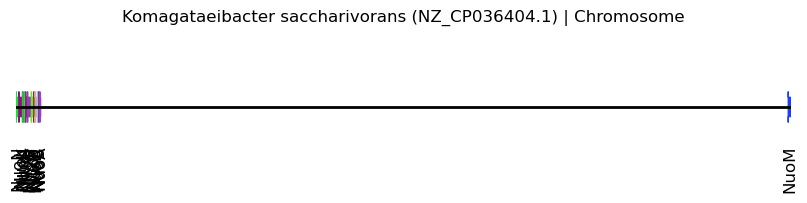

In [167]:
# Visualize operon
plot_operon(gene_tuples, species_info)

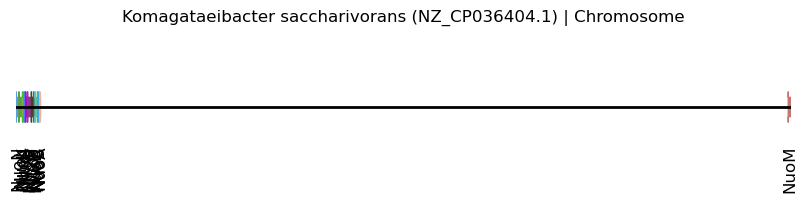

In [168]:
# Visualize operon
plot_operon(gene_tuples, species_info)

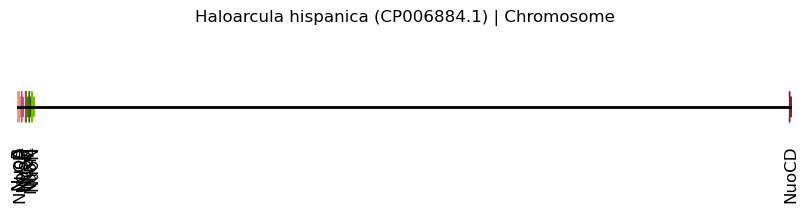

In [169]:
species_info = extract_genome_info(nuohmmer_filtered, accession)
gene_tuples = extract_gene_tuples(nuohmmer_filtered, species_info)
plot_operon(gene_tuples, species_info)

In [170]:
accession_ids = nuo_bool_final[(nuo_bool_final['Replicon']=='Plasmid') & (nuo_bool_final['Variation']!='Nuo-Partial')]['Accession'].unique()

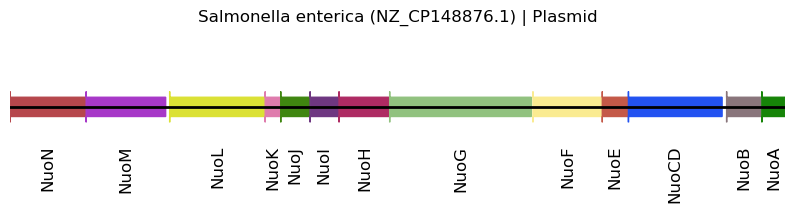

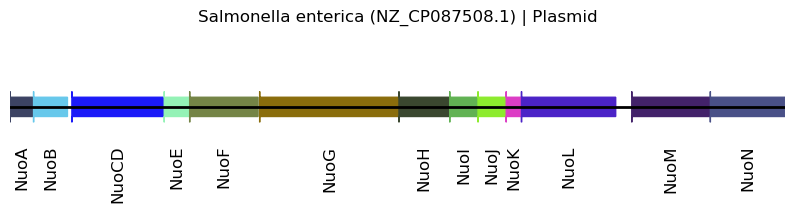

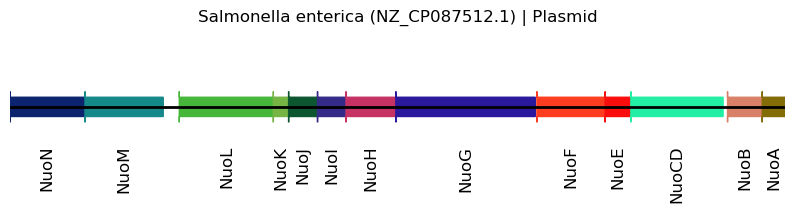

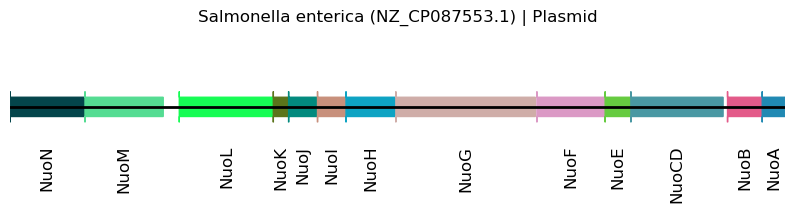

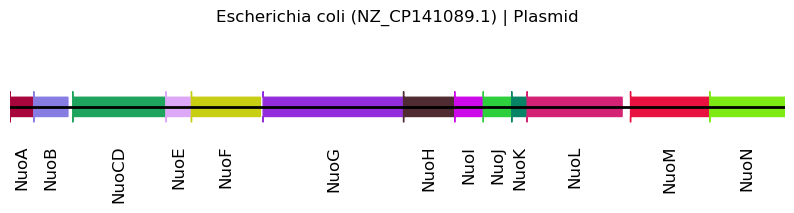

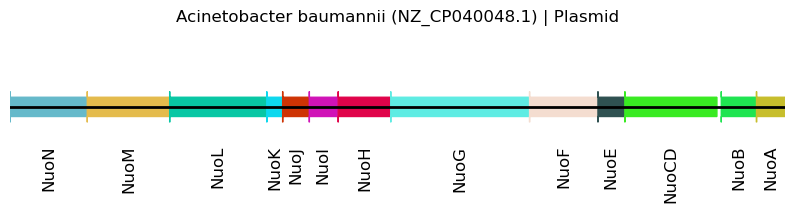

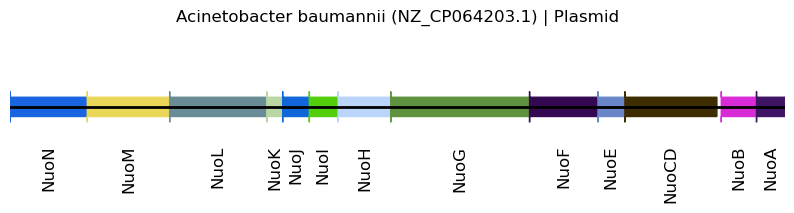

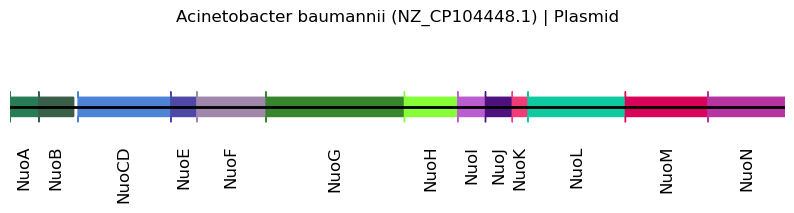

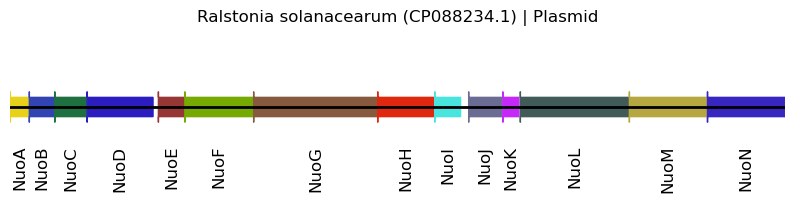

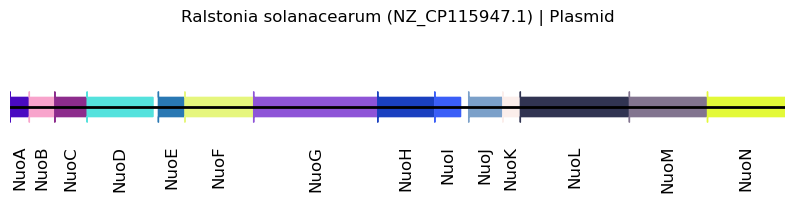

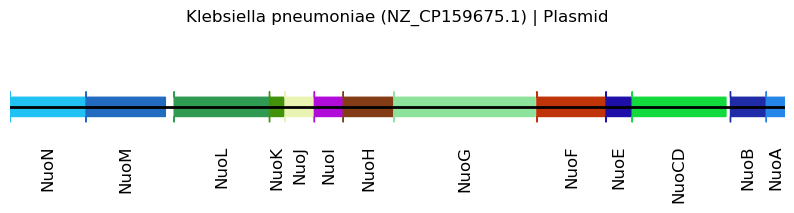

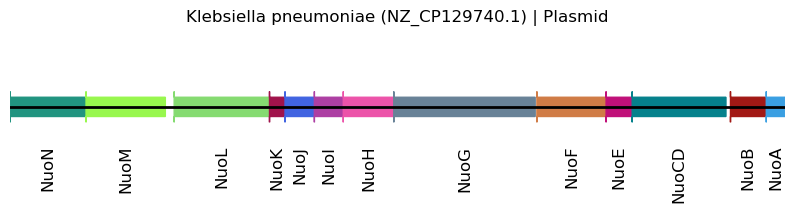

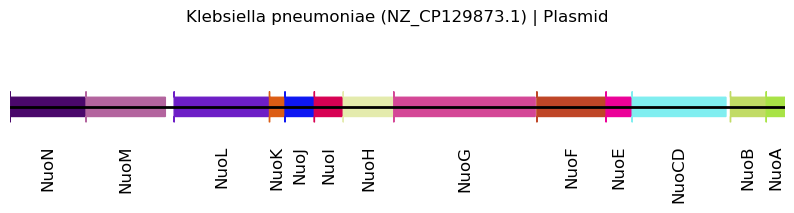

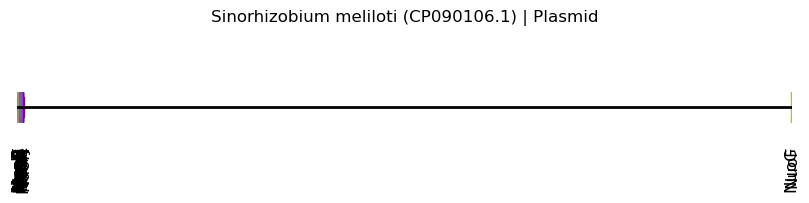

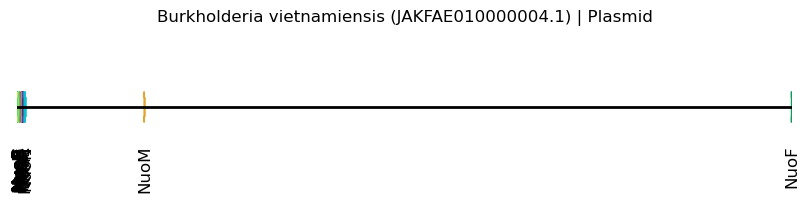

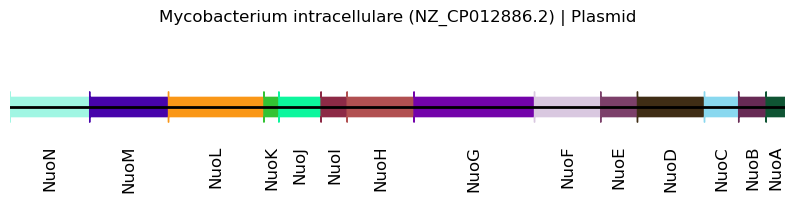

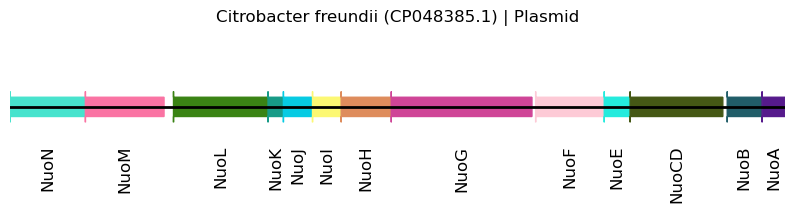

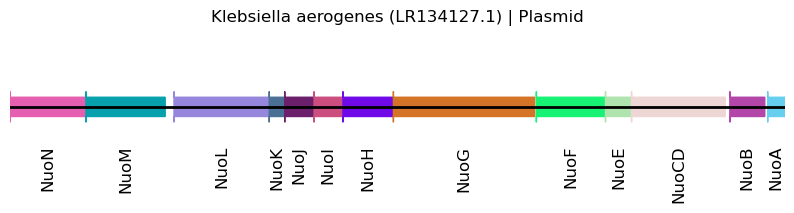

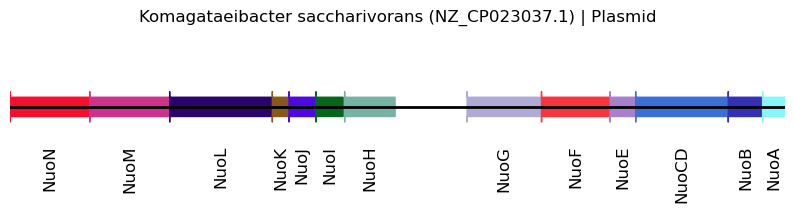

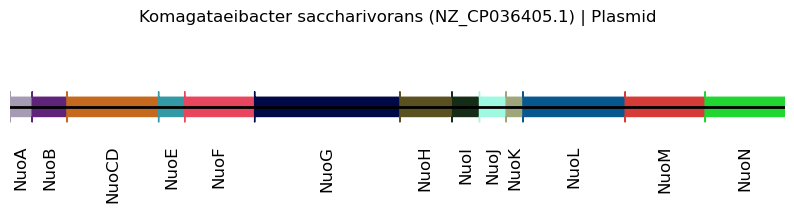

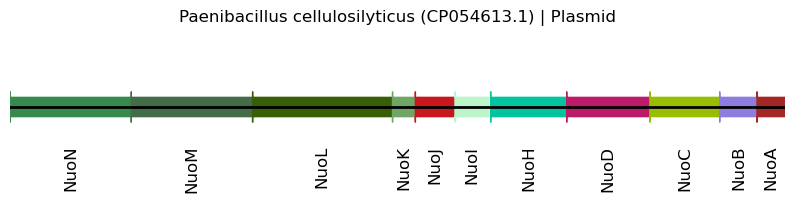

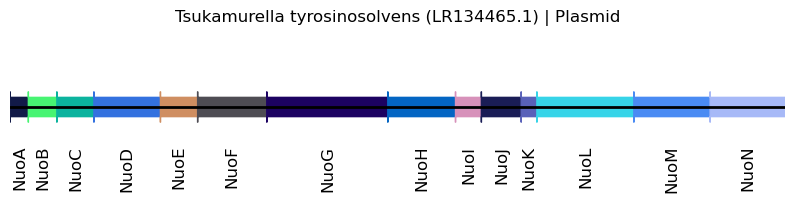

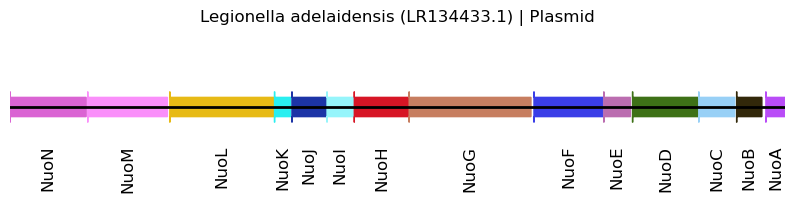

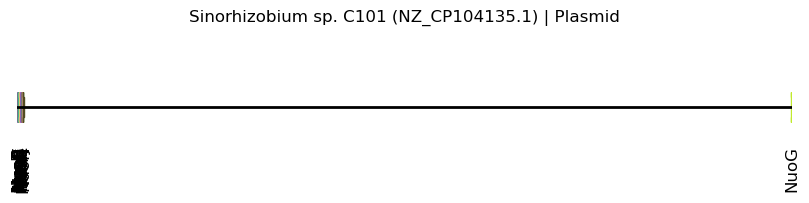

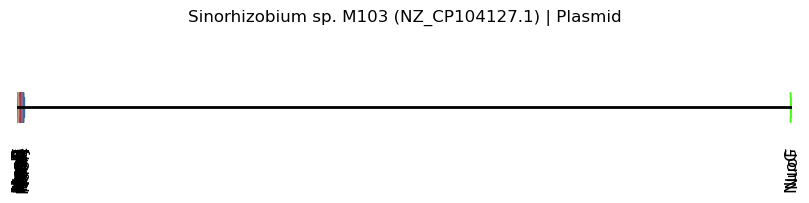

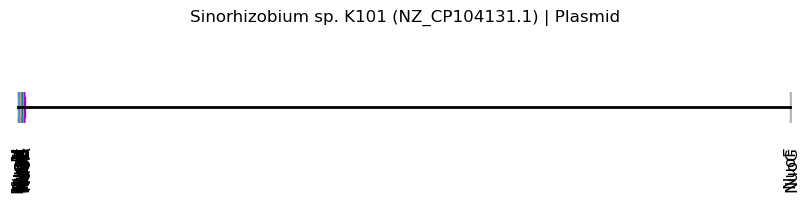

In [171]:
for accession in accession_ids:
    species_info = extract_genome_info(nuohmmer_filtered, accession)
    gene_tuples = extract_gene_tuples(nuohmmer_filtered, species_info)
    plot_operon(gene_tuples, species_info)

In [172]:
nuo_bool_final[nuo_bool_final['Phylum']=='Mycoplasmatota']['Class'].value_counts()

Class
Mollicutes                1
Candidatus Izimaplasma    1
Name: count, dtype: int64

In [173]:
# taxonomy[taxonomy['Mollicutes']=='Mycoplasmatota']['Class'].value_counts()

In [174]:
nuo_bool_final[nuo_bool_final['Class']=='Terriglobia']['Species'].value_counts()

Species
Terriglobus roseus               2
Acidobacterium capsulatum        1
Alloacidobacterium dinghuense    1
uncultured Granulicella sp.      1
Edaphobacter sp. 4G125           1
Granulicella sp. 5B5             1
Terriglobus albidus              1
Edaphobacter flagellatus         1
Occallatibacter riparius         1
Paludibaculum fermentans         1
Granulicella mallensis           1
Edaphobacter lichenicola         1
Edaphobacter sp. 12200R-103      1
Acidisarcina polymorpha          1
Granulicella sp. WH15            1
Granulicella tundricola          1
Terriglobus saanensis            1
uncultured Paludibaculum sp.     1
Name: count, dtype: int64

In [175]:
nuo_bool_final[nuo_bool_final['Class']=='Holophagae']['Species'].value_counts()

Species
Thermotomaculum hydrothermale    1
Sulfidibacter corallicola        1
Mesoterricola silvestris         1
Mesoterricola sediminis          1
Geothrix oryzae                  1
Geothrix sp. 21YS21S-2           1
Geothrix sp. PMB-07              1
Geothrix sp. 21YS21S-4           1
Geothrix sp.                     1
uncultured Holophaga sp.         1
Name: count, dtype: int64

In [176]:
nuo_bool_final['Phylum'].value_counts()

Phylum
Pseudomonadota             22973
Actinomycetota              3025
Bacillota                   1666
Campylobacterota            1171
Bacteroidota                1153
Euryarchaeota                351
Cyanobacteriota              344
Thermodesulfobacteriota      131
Verrucomicrobiota            131
Spirochaetota                115
Thermoproteota                98
Deinococcota                  86
Myxococcota                   57
Planctomycetota               57
Chloroflexota                 47
Thermotogota                  44
Acidobacteriota               41
Bdellovibrionota              33
Fusobacteriota                30
Aquificota                    19
Nitrososphaerota              17
Chlorobiota                   16
Rhodothermota                 15
Nitrospirota                  15
Synergistota                  10
Deferribacterota               6
Gemmatimonadota                5
Ignavibacteriota               3
Armatimonadota                 3
Dictyoglomota                  2
The

In [177]:
nuo_bool_final[nuo_bool_final['Species'].str.startswith('Desulfonema')]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
19119,Thermodesulfobacteriota,Desulfobacteria,Desulfonema limicola,CP061799.1,GCA_017377355.1_ASM1737735v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
19120,Thermodesulfobacteriota,Desulfobacteria,Desulfonema magnum,CP061800.1,GCA_017377395.1_ASM1737739v1_genomic.fna,Chromosome,Bacteria,False,False,False,...,False,True,False,False,False,False,False,False,False,Nuo-Partial


In [178]:
nuo_bool_final[nuo_bool_final['Class']=='Desulfobacteria']['Species'].nunique()

15

In [179]:
nuo_bool_final[nuo_bool_final['Class']=='Desulfobacteria']['Variation'].value_counts()

Variation
Nuo-Partial    12
Nuo12           5
Name: count, dtype: int64

In [180]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Class'].value_counts()

Class
Desulfuromonadia         46
Desulfovibrionia         42
Desulfobacteria          17
Desulfobulbia            12
Thermodesulfobacteria     7
Syntrophobacteria         2
Desulfarculia             2
Syntrophia                1
Desulfomonilia            1
Desulfobaccia             1
Name: count, dtype: int64

In [181]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']!='Nuo-Partial')]['Class'].value_counts()

Class
Desulfuromonadia         9
Thermodesulfobacteria    7
Desulfobacteria          5
Desulfovibrionia         4
Desulfobulbia            2
Desulfarculia            1
Name: count, dtype: int64

In [182]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]['Class'].value_counts()

Class
Desulfobacteria     5
Desulfuromonadia    4
Desulfarculia       1
Name: count, dtype: int64

In [183]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo14-EF')]['Class'].value_counts()

Class
Desulfuromonadia    4
Name: count, dtype: int64

In [184]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo14-EFG')]['Class'].value_counts()

Class
Thermodesulfobacteria    7
Desulfovibrionia         4
Desulfuromonadia         1
Desulfobulbia            1
Name: count, dtype: int64

In [185]:
genomes_dataset[genomes_dataset['Phylum']=='Thermodesulfobacteriota']['Class'].value_counts()

Class
Desulfovibrionia         58
Desulfuromonadia         46
Desulfobacteria          28
Desulfobulbia            13
Thermodesulfobacteria     7
Syntrophobacteria         2
Desulfarculia             2
Syntrophia                1
Desulfomonilia            1
Desulfobaccia             1
Name: count, dtype: int64

In [186]:
genomes_dataset[genomes_dataset['Phylum']=='Thermodesulfobacteriota']['Class'].nunique()

10

In [187]:
genomes_dataset[genomes_dataset['Phylum']=='Bacillota']['Class'].value_counts()

Class
Bacilli             9450
Clostridia          1035
Negativicutes         68
Erysipelotrichia      52
Tissierellia          47
Limnochordia           3
Name: count, dtype: int64

In [188]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Bacillota') & (nuo_bool_final['Variation']=='Nuo14')]['Class'].value_counts()

Class
Clostridia      4
Limnochordia    3
Bacilli         1
Name: count, dtype: int64

In [189]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Bacillota') & (nuo_bool_final['Variation']=='Nuo13')]['Class'].value_counts()

Class
Bacilli    1
Name: count, dtype: int64

In [190]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Bacillota') & (nuo_bool_final['Variation']=='Nuo14-EFG')]['Class'].value_counts()

Class
Bacilli       128
Clostridia      4
Name: count, dtype: int64

In [191]:
bacillota_all = set(genomes_dataset[genomes_dataset['Phylum']=='Bacillota']['Species'])
bacillota_nuo = set(nuo_bool_final[nuo_bool_final['Phylum']=='Bacillota']['Species'])

In [192]:
genomes_dataset[genomes_dataset['Species'].isin(bacillota_all.difference(bacillota_nuo))]['Class'].value_counts()

Class
Bacilli             5594
Clostridia           359
Erysipelotrichia      47
Negativicutes         33
Tissierellia          12
Name: count, dtype: int64

In [193]:
genomes_dataset.head(1)

,Organism,Species,LineageTaxIDs,Strain,TaxID,Group,SubGroup,Size (Mb),GC%,Genes,...,Assembly Accession,Reference,FTP Path,GenomePath,CDSPath,GenomeFile,CDSFile,ProteomeFile,Class,Phylum
0,Bacteria,Campylobacter jejuni,197,Campylobacter jejuni subsp. jejuni NCTC 11168 ...,192222,Campylobacterota,Epsilonproteobacteria,1.64148,30.5,1668,...,GCA_000009085.1,REFR,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,GCA_000009085.1_ASM908v1_genomic.fna,GCA_000009085.1_ASM908v1_cds_from_genomic.fna,GCA_000009085.1_ASM908v1_cds_proteins.faa,Epsilonproteobacteria,Campylobacterota


In [194]:
selected = ['Organism', 'Species', 'LineageTaxIDs', 'Strain', 'TaxID', 'Size (Mb)', 'Assembly Accession', 'Reference', 'FTP Path']

In [195]:
genomes_dataset[selected].to_csv('/Users/akshayonly/Work/Submission-Data/genomes_dataset.csv', index=False)

In [196]:
taxonomy = taxonomy[taxonomy['Species'].isin(genomes_dataset['Species'])].drop_duplicates()
taxonomy.to_csv('/Users/akshayonly/Work/Submission-Data/taxonomy.csv', index=False)

In [197]:
genomes_dataset[genomes_dataset['LineageTaxIDs']==562]['Assembly Accession'].nunique()

3787

In [198]:
genomes_metadata = genomes_metadata[['Accession', 'Replicon', 'GenomeFile']].merge(genomes_dataset[['Assembly Accession', 'GenomeFile']])

In [199]:
nuohmmer_filtered.head(1)

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster,Species
0,AP024266.1,Chromosome,GCA_016755935.1_ASM1675593v1_genomic.fna,5.921363,GCA_016755935.1_ASM1675593v1_cds_proteins.faa,AP024266.1_4302,2.400000e-49,166.0,1.9,# 4565910 # 4566389 # 1 # ID=1_4302;partial=00...,NuoA,85,FinedTuned2,4565910,4566389,-48.619789,159,1,8,Mycobacterium intracellulare


In [200]:
print(nuohmmer_filtered.columns.tolist())

['Accession', 'Replicon', 'GenomeFile', 'SequenceLength(Mb)', 'ProteomeFile', 'ProteinAccession', 'evalue', 'BitScore', 'Bias', 'SequenceDesc', 'Subunit', 'SeqsClustThreshold', 'HMMParameter', 'Start', 'End', 'log10evalue', 'EstProtLength', 'Strand', 'Cluster', 'Species']


In [201]:
selected = ['Accession', 'Replicon', 'ProteinAccession', 'evalue', 'BitScore', 'Bias', 'SequenceDesc', 'Subunit', 'Start', 'End', 'log10evalue', 'EstProtLength', 'Strand', 'Cluster', 'Species']

In [202]:
selected = ['Assembly Accession', 'Accession', 'Species', 'Replicon', 'SequenceDesc', 'ProteinAccession', 'evalue', 'BitScore', 'Bias', 'Subunit', 'Start', 'End', 'log10evalue', 'EstProtLength', 'Strand', 'Cluster']

In [203]:
species_counts = genomes_dataset.groupby('Species')['Assembly Accession'].nunique().reset_index()

# Rename the columns for clarity
species_counts.columns = ['Species', 'Unique Assembly Count']

In [204]:
species_counts = species_counts.sort_values('Unique Assembly Count', ascending=False)

In [205]:
species_counts

,Species,Unique Assembly Count
3109,Escherichia coli,3787
4183,Klebsiella pneumoniae,2304
8381,Salmonella enterica,1997
8976,Staphylococcus aureus,1549
7229,Pseudomonas aeruginosa,993
...,...,...
5001,Metamycoplasma subdolum,1
5000,Metamycoplasma salivarium,1
4999,Metamycoplasma phocicerebrale,1
4998,Metamycoplasma orale,1


In [206]:
nuo_bool.head()

,Accession,GenomeFile,Replicon,Organism,Species,Cluster,Strand,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
0,AP024266.1,GCA_016755935.1_ASM1675593v1_genomic.fna,Chromosome,Bacteria,Mycobacterium intracellulare,8,1,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
1,AP024247.1,GCA_016756255.1_ASM1675625v1_genomic.fna,Chromosome,Bacteria,Mycobacterium intracellulare,6,1,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
2,FR878060.1,GCA_000253355.1_ASM25335v1_genomic.fna,Chromosome,Bacteria,Mycobacterium tuberculosis,7,1,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
3,AP025193.1,GCA_020886175.1_ASM2088617v1_genomic.fna,Chromosome,Bacteria,Comamonas thiooxydans,4,1,True,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
4,CP069060.1,GCA_018467135.1_ASM1846713v1_genomic.fna,Chromosome,Bacteria,Wolbachia endosymbiont of Drosophila santomea,1,-1,False,False,False,...,False,True,True,False,False,False,False,False,False,Nuo-Partial


In [207]:
# Group by 'Species' and count genome files
all_species_summary = genomes_dataset.groupby('Species', as_index=False).agg(
    Total_GenomeFiles=('GenomeFile', 'count')
)

# Group by 'Species' and count genome files for nuo_bool subset
species_summary = nuo_bool.groupby('Species', as_index=False).agg(
    Total_GenomeFiles=('GenomeFile', 'count')
)

# Count genome variations per species
variation_counts = nuo_bool_final.pivot_table(index='Species', columns='Variation', aggfunc='size', fill_value=0).reset_index()

# Merge species summary with variation counts
summary_df = species_summary.merge(variation_counts, on='Species', how='left')

# Sort by total genome files
summary_df = summary_df.sort_values(by='Total_GenomeFiles', ascending=False)

# Identify absent species
absent_species_summary = all_species_summary[~all_species_summary['Species'].isin(species_summary['Species'])]

# Add variation columns with NaN for absent species
variation_columns = ['Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG']
absent_species_summary = absent_species_summary.assign(**{col: None for col in variation_columns})

# Combine both summaries
summary = pd.concat([summary_df, absent_species_summary], ignore_index=True)

# Rename column for clarity
summary.rename(columns={'Total_GenomeFiles': 'Total Genomes'}, inplace=True)

# Merge with taxonomy data, dropping duplicates and unnecessary columns
result = taxonomy.drop(columns=['Strain']).merge(summary, on='Species', how='right')

In [208]:
result.drop(columns=['LineageTaxIDs', 'TaxID'], inplace=True)

In [209]:
result.drop_duplicates(inplace=True)

In [210]:
result.to_excel('/Users/akshayonly/Work/Submission-Data/species_nuo_information.xlsx')

In [3]:
float(1e-10)

1e-10